In [132]:
%%time
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum
# this will try to fix the random number when seeded

# Для 20 вершин объем грузовика 500, для 50 вершин объем грузовика 750, для 50 вершин объем грузовика 1000
TW_CAPACITIES = {
    20: 30.,
    50: 40.,
    100: 50.,
    500: 70.
}
rnd = np.random
rnd.seed(0)

lst_time = []
lst = []
time_limit = 600
n_customer = 100
max_vehicle = 50
n_samples = 100

k = 0
min_capasity = 1
max_capasity = 42

#------------------------------#
# Определяем сколько грузовиков нам понадобится и в зависимости от этого увеличиваем максимальный объем вместимости
n = 2
max_vehicle *= n
while(max_vehicle < max_capasity):
    max_vehicle = max_vehicle / n
    n += 1
    max_vehicle *= n
print("Используется грузовиков: ", n)
#------------------------------#

# parameters for the capacitated vehicle routing problem
all_xc = [] * n_samples
all_yc = [] * n_samples

n = n_customer # кол-во вершин
N = [i for i in range(1, n)] # tour без депо
V = [0] + N # tour с депо

A = [(i,j) for i in V for j in V if i != j] # possible arcs

all_c = [] * n_samples

Q = max_vehicle
all_q = [] * n_samples

# Заполняем n_samples примеров и только для них будем получать результаты
for j in range(0, n_samples):
    cities = rnd.uniform(size=(n_customer, 2))
            #print('cities:', cities)
    xc = np.zeros(n_customer)
    yc = np.zeros(n_customer)

    for i in range(0, len(cities)):
        xc[i] = cities[i][0]
        yc[i] = cities[i][1]
    
    capacity = np.minimum(np.maximum(np.abs(np.random.normal(15, 10, size=[n_samples, n_customer])), min_capasity), max_capasity)
    c = {(i,j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for (i,j) in A} # расстояния между соседними городами
    q = {i: capacity[k][i] for i in N} # number of VRUs at location i to be picked
    
    all_xc.append(xc)
    all_yc.append(yc)
    all_c.append(c)
    all_q.append(q)
    
while(k < n_samples):
    for i in range(0, len(cities)):
        xc[i] = all_xc[k][i]
        yc[i] = all_yc[k][i]

    c = all_c[k] # расстояния между соседними городами


    q = all_q[k] # number of VRUs at location i to be picked
#-----------------------------------------------------------------------------------------------------------------#        
    model = Model('CVRP')

    # Declaration of variables
    x = model.addVars(A, vtype= GRB.BINARY)
    y = model.addVars(N, vtype= GRB.CONTINUOUS)
    # setting the objective function
    model.modelSense = GRB.MINIMIZE
    model.setObjective(quicksum(x[i, j]*c[i, j] for i, j in A))

    # Adding constraints
    model.addConstrs(quicksum(x[i,j] for j in V if j!=i) == 1 for i in N)
    model.addConstrs(quicksum(x[i,j] for i in V if i!=j) == 1 for j in N)
    model.addConstrs((x[i,j] == 1) >> (y[i] + q[j] == y[j]) for (i,j) in A if i != 0 and j != 0)
    model.addConstrs(y[i] >= q[i] for i in N)
    model.addConstrs(y[k] <= Q for k in N)

    # Optimizing the model
#         model.Params.MIPGap = 0.1
    model.Params.TimeLimit = time_limit  # seconds
    model.Params.LogFile= "result.txt"
    model.optimize()
    if model.status == GRB.OPTIMAL:
        print('1.Optimal objective: %g' % model.objVal)
        print('Optimal cost: %g' % model.objVal)
        lst.append(model.objVal)
        lst_time.append(model.Runtime)
    elif model.status == GRB.INF_OR_UNBD:
        print('2.Model is infeasible or unbounded')
        res = -1
    elif model.status == GRB.INFEASIBLE:
        print('3.Model is infeasible')
        res = -1
    elif model.status == GRB.UNBOUNDED:
        print('4.Model is unbounded')
        res = -1
    else:
        print('5.Optimization ended with status %d' % model.status)
        print('Optimal cost: %g' % model.objVal)
        lst.append(model.objVal)
        lst_time.append(time_limit)
    k += 1
#-----------------------------------------------------------------------------------------------------------------#  

#         if(res == -1):
#             plt.figure()
#             plt.plot(xc[0], yc[0], c='r', marker='s')
#             plt.scatter(xc[1:], yc[1:], c='b')
#         else:
#             active_arcs = [a for a in A if x[a].x > 0.99]
#             plt.figure()
#             for i, j in active_arcs:
#                 plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='g', zorder=0)
#                 plt.plot(xc[0], yc[0], c='r', marker='s')
#                 plt.scatter(xc[1:], yc[1:], c='b')

Используется грузовиков:  2
Academic license - for non-commercial use only - expires 2021-12-11
Using license file C:\Users\German\gurobi.lic
Changed value of parameter TimeLimit to 600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter LogFile to result.txt
   Prev:   Default: 
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 396 rows, 9999 columns and 19800 nonzeros
Model fingerprint: 0x98b5e10e
Model has 9702 general constraints
Variable types: 99 continuous, 9900 integer (9900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve added 24061 rows and 4855 columns
Presolve time: 2.19s
Presolved: 24457 rows, 14854 columns, 144810 nonzeros
Variable types: 4950 continuous, 9904 integer (9900 binary)

Deterministic concurrent LP optimizer:

  2737  2852   13.34328  726  147   20.92006    7.61729  63.6%  32.1  447s
  2864  3026   13.50872  759  126   20.92006    7.61729  63.6%  32.1  456s
  3040  3158   13.78093  826  139   20.92006    7.61729  63.6%  31.4  465s
  3172  3293   14.56203  862  121   20.92006    7.61729  63.6%  31.5  474s
  3307  3297   14.87065  904  131   20.92006    7.61729  63.6%  31.3  497s
H 3309  3297                      20.8942968    7.61729  63.5%  31.3  497s
  3311  3415   14.87203  905  132   20.89430    7.61729  63.5%  31.3  511s
  3429  3574   15.20458  938  126   20.89430    7.61729  63.5%  31.4  522s
  3590  3590   15.60893  991  112   20.89430    7.61729  63.5%  31.2  537s
H 3593  3590                      20.8468466    7.61729  63.5%  31.2  537s
  3606  3787   15.61783  995  119   20.84685    7.61729  63.5%  31.2  548s
  3803  3961   15.89329 1038  122   20.84685    7.61729  63.5%  30.9  558s
  3978  4112   17.06595 1075  107   20.84685    7.61729  63.5%  30.9  570s
  4129  4332   17.76898 1

H 1823  1884                      25.3536633    7.35611  71.0%  39.2  255s
  1889  1994   13.40339  470  167   25.35366    7.35611  71.0%  38.7  272s
  1999  2101   13.57459  488  163   25.35366    7.35611  71.0%  37.9  287s
  2106  2202   14.92089  523  157   25.35366    7.35611  71.0%  37.1  302s
  2209  2313   15.24175  531  145   25.35366    7.35611  71.0%  36.7  317s
  2320  2413   15.46010  562  130   25.35366    7.35611  71.0%  36.0  335s
  2421  2442   15.87400  582  123   25.35366    7.35611  71.0%  35.7  349s
H 2422  2442                      25.3530321    7.35611  71.0%  35.7  349s
H 2441  2442                      25.1300917    7.35611  70.7%  35.6  349s
  2450  2540   15.88435  583  130   25.13009    7.35611  70.7%  35.7  366s
  2548  2676   16.13027  610  122   25.13009    7.35611  70.7%  35.6  389s
  2684  2796   16.38542  650  130   25.13009    7.35611  70.7%  35.0  406s
  2804  2912   16.84605  684  123   25.13009    7.35611  70.7%  34.7  420s
H 2837  2912             

   390   418    8.50337   72  188   24.26664    7.72653  68.2%  50.3  206s
   417   435    8.54703   77  183   24.26664    7.72653  68.2%  48.8  212s
   436   460    8.60434   79  192   24.26664    7.72653  68.2%  48.4  216s
H  461   465                      24.2511422    7.72653  68.1%  47.5  224s
H  462   465                      24.2304539    7.72653  68.1%  47.5  224s
H  463   465                      24.1294945    7.72653  68.0%  47.4  224s
   466   484    8.63724   85  191   24.12949    7.72653  68.0%  47.5  234s
   485   516    8.66592   90  169   24.12949    7.72653  68.0%  46.9  239s
   517   543    8.74213   97  163   24.12949    7.72653  68.0%  46.2  244s
   544   569    8.80574  104  174   24.12949    7.72653  68.0%  46.1  249s
   570   598    8.92342  111  168   24.12949    7.72653  68.0%  46.0  256s
   599   626    8.97479  118  171   24.12949    7.72653  68.0%  45.4  263s
   627   661    9.01794  124  170   24.12949    7.72653  68.0%  45.3  268s
   662   702    9.11132  

H   62    63                      25.4345255    7.21757  71.6%  59.6   84s
H   63    63                      24.6175133    7.21757  70.7%  59.9   84s
    66    69    7.53431   15  211   24.61751    7.21757  70.7%  59.8   85s
    91    94    7.56285   19  182   24.61751    7.21757  70.7%  56.1   92s
H   93    94                      24.2424284    7.21757  70.2%  55.1   92s
H   95    94                      24.1983566    7.21757  70.2%  55.0   92s
   112   119    7.56728   21  190   24.19836    7.21757  70.2%  52.8   96s
   130   134    7.58413   24  181   24.19836    7.21757  70.2%  52.2  100s
   158   163    7.82635   29  175   24.19836    7.21757  70.2%  50.0  105s
   193   203    7.81676   38  172   24.19836    7.21757  70.2%  47.0  111s
   223   227    7.83235   40  171   24.19836    7.21757  70.2%  45.0  116s
   249   260    7.88255   44  168   24.19836    7.21757  70.2%  43.6  121s
H  272   268                      23.6871836    7.21757  69.5%  42.9  122s
   274   284    7.91943  

H    0     0                      32.2013181    7.41264  77.0%     -   22s
     0     0    7.41264    0  216   32.20132    7.41264  77.0%     -   22s
H    0     0                      29.0096684    7.41264  74.4%     -   24s
     0     0    7.41476    0  211   29.00967    7.41476  74.4%     -   24s
     0     0    7.41476    0  211   29.00967    7.41476  74.4%     -   25s
     0     0    7.41476    0  203   29.00967    7.41476  74.4%     -   27s
H    0     0                      28.8609437    7.41476  74.3%     -   28s
     0     0    7.41476    0  205   28.86094    7.41476  74.3%     -   28s
     0     0    7.41476    0  202   28.86094    7.41476  74.3%     -   31s
     0     0    7.41476    0  211   28.86094    7.41476  74.3%     -   32s
     0     0    7.41509    0  211   28.86094    7.41509  74.3%     -   35s
     0     0    7.41509    0  211   28.86094    7.41509  74.3%     -   49s
H    0     0                      26.9959902    7.41509  72.5%     -   50s
     0     2    7.43470  

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.42337    0  197          -    6.42337      -     -    5s
H    0     0                     131.9529283    6.42337  95.1%     -    5s
H    0     0                      54.1896162    6.42337  88.1%     -    6s
H    0     0                      54.0147952    6.42337  88.1%     -    9s
H    0     0                      46.0826874    6.42337  86.1%     -   13s
     0     0    6.94571    0  202   46.08269    6.94571  84.9%     -   15s
     0     0    6.94571    0  201   46.08269    6.94571  84.9%     -   17s
     0     0    6.98454    0  220   46.08269    6.98454  84.8%     -   21s
     0     0    6.99227    0  216   46.08269    6.99227  84.8%     -   22s
     0     0    6.99232    0  216   46.08269    6.99232  84.8%     -   23s
     0     0    7.03468    0  217   46.08269    7.03468  84.7%     -   26s
H    0     0                      44.0430521    7.03468  84.0%     -   27s
     0     0    7.0428

Thread count was 8 (of 8 available processors)

Solution count 10: 36.157 36.5785 36.5932 ... 38.2511

Time limit reached
Best objective 3.615695313863e+01, best bound 7.125966982755e+00, gap 80.2916%
5.Optimization ended with status 9
Optimal cost: 36.157
Changed value of parameter TimeLimit to 600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter LogFile to result.txt
   Prev:   Default: 
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 396 rows, 9999 columns and 19800 nonzeros
Model fingerprint: 0x67de9432
Model has 9702 general constraints
Variable types: 99 continuous, 9900 integer (9900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve added 24057 rows and 4851 columns
Presolve time: 1.33s
Presolved: 24453 rows, 14850 columns, 

H 2690  2715                      24.7153213    7.33288  70.3%  32.0  252s
H 2721  2715                      24.6166935    7.33288  70.2%  32.0  252s
  2722  2817   15.43325  601  131   24.61669    7.33288  70.2%  32.0  259s
  2824  2927   15.61830  628  135   24.61669    7.33288  70.2%  32.1  265s
  2934  3013   15.89740  653  123   24.61669    7.33288  70.2%  31.9  280s
H 2958  3013                      24.6044406    7.33288  70.2%  32.0  280s
  3020  3017   16.15786  674  118   24.60444    7.33288  70.2%  32.5  290s
H 3021  3017                      24.4613354    7.33288  70.0%  32.5  290s
  3024  3141   16.16058  675  117   24.46134    7.33288  70.0%  32.5  297s
  3149  3300   16.55092  712  109   24.46134    7.33288  70.0%  32.4  305s
  3308  3453   17.00138  744  113   24.46134    7.33288  70.0%  32.0  312s
  3461  3626   17.26459  776  118   24.46134    7.33288  70.0%  31.8  320s
  3634  3813   17.85235  802  109   24.46134    7.33288  70.0%  31.4  328s
  3821  3984   18.35502  

  1153  1192   10.68366  288  166   34.07994    6.97184  79.5%  36.5  196s
  1197  1237   11.16634  295  148   34.07994    6.97184  79.5%  36.9  201s
H 1230  1237                      33.9799125    6.97184  79.5%  37.0  201s
  1242  1307   11.35770  301  157   33.97991    6.97184  79.5%  37.0  205s
  1359  1373   12.12403  318  145   33.97991    6.97184  79.5%  36.8  226s
H 1363  1373                      33.8658793    6.97184  79.4%  36.7  226s
H 1374  1373                      32.6998907    6.97184  78.7%  36.6  226s
  1378  1459   12.01229  323  146   32.69989    6.97184  78.7%  36.6  237s
  1464  1533   12.27267  350  135   32.69989    6.97184  78.7%  35.9  243s
  1538  1603   12.52239  363  157   32.69989    6.97184  78.7%  35.5  248s
  1608  1674   13.02256  372  125   32.69989    6.97184  78.7%  35.3  252s
  1680  1738   13.24855  383  139   32.69989    6.97184  78.7%  35.1  256s
  1744  1787   13.40713  398  148   32.69989    6.97184  78.7%  35.0  265s
H 1757  1787             

   415   420    8.82477   68  180   25.99414    7.96268  69.4%  38.7  100s
H  417   420                      25.9723913    7.96268  69.3%  38.5  100s
   465   489    9.07984   78  170   25.97239    7.96268  69.3%  39.5  106s
   537   556    9.27939   93  160   25.97239    7.96268  69.3%  39.2  111s
   582   609    9.50210  105  181   25.97239    7.96268  69.3%  40.1  115s
   670   709   10.04280  125  166   25.97239    7.96268  69.3%  39.9  120s
   745   792   10.03213  139  173   25.97239    7.96268  69.3%  39.0  125s
   833   876   10.15869  162  168   25.97239    7.96268  69.3%  37.5  130s
   920   961   10.35283  181  152   25.97239    7.96268  69.3%  37.5  135s
  1015  1061   10.60563  205  159   25.97239    7.96268  69.3%  37.7  140s
  1110  1147   10.80853  228  155   25.97239    7.96268  69.3%  37.8  146s
H 1149  1160                      25.9153842    7.96268  69.3%  38.2  151s
  1207  1257   11.03095  248  163   25.91538    7.96268  69.3%  38.5  157s
  1260  1337   11.23117  

     0     0    7.54607    0  219   24.82279    7.54607  69.6%     -   18s
     0     0    7.54715    0  223   24.82279    7.54715  69.6%     -   19s
     0     0    7.54715    0  218   24.82279    7.54715  69.6%     -   20s
     0     0    7.54715    0  219   24.82279    7.54715  69.6%     -   21s
     0     0    7.54715    0  219   24.82279    7.54715  69.6%     -   22s
     0     0    7.54715    0  210   24.82279    7.54715  69.6%     -   24s
H    0     0                      24.8048515    7.54715  69.6%     -   26s
H    0     0                      24.1981207    7.54715  68.8%     -   26s
     0     0    7.54715    0  203   24.19812    7.54715  68.8%     -   31s
H    0     0                      22.4605564    7.54715  66.4%     -   32s
     0     2    7.60624    0  203   22.46056    7.60624  66.1%     -   32s
     7    12    7.60624    3  219   22.46056    7.60624  66.1%   108   35s
H   28    33                      22.2420598    7.60624  65.8%  92.8   38s
    56    64    7.61683  

Variable types: 4950 continuous, 9900 integer (9900 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 6.634374e+00, 380 iterations, 0.31 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.63437    0  202          -    6.63437      -     -    2s
H    0     0                      93.6684692    6.63437  92.9%     -    2s
H    0     0                      39.3340786    6.63437  83.1%     -    3s
H    0     0                      38.9480087    6.63437  83.0%     -    4s
     0     0    7.30584    0  206   38.94801    7.30584  81.2%     -    6s
H    0     0                      35.7271184    7.30584  79.6%     -    8s
H    0     0                      33.0963850    7.30584  77.9%     -    8s
     0     0    7.34833    0  204   33.09638   

  5159  5107    8.12413   63  202   25.65518    7.46845  70.9%  28.4  411s
  5161  5108    9.32442  138  195   25.65518    7.46845  70.9%  28.3  429s
  5162  5109   17.32645  669  216   25.65518    7.46845  70.9%  28.3  442s
  5163  5110   10.02611  170  227   25.65518    7.51943  70.7%  28.3  451s
H 5163  4854                      25.6386448    7.51943  70.7%  28.3  462s
  5165  4855   11.99642  290  243   25.63864    7.53288  70.6%  28.3  475s
  5166  4856   10.27973  374  234   25.63864    7.54229  70.6%  28.3  488s
  5167  4856   11.51315  297  233   25.63864    7.54580  70.6%  28.3  497s
  5168  4857    7.65405   19  230   25.63864    7.57127  70.5%  28.3  509s
  5169  4858   22.01244 1099  235   25.63864    7.57583  70.5%  28.3  519s
H 5169  4615                      25.6204463    7.57583  70.4%  28.3  531s
  5171  4616   22.65913 1168  231   25.62045    7.58717  70.4%  28.3  547s
H 5171  4385                      25.5875753    7.58717  70.3%  28.3  558s
  5172  4386   19.48637  

H 2280  2295                      21.7651525    7.66484  64.8%  28.3  196s
  2306  2449   16.14339  498  134   21.76515    7.66484  64.8%  28.4  203s
  2460  2614   16.31672  534  116   21.76515    7.66484  64.8%  27.8  210s
  2625  2737   17.14183  574  124   21.76515    7.66484  64.8%  27.4  217s
  2748  2869   17.43650  602  117   21.76515    7.66484  64.8%  27.2  224s
  2880  3041   17.76541  635  113   21.76515    7.66484  64.8%  27.2  234s
  3052  3178   17.97481  682  118   21.76515    7.66484  64.8%  26.8  251s
  3189  3304   18.12875  715  110   21.76515    7.66484  64.8%  26.8  259s
  3315  3468   19.08248  736  124   21.76515    7.66484  64.8%  26.9  269s
  3479  3630   19.88646  760  107   21.76515    7.66484  64.8%  26.7  283s
  3645  3813   20.22397  793  111   21.76515    7.66484  64.8%  26.7  295s
  3829  4029   20.50835  852  103   21.76515    7.66484  64.8%  26.5  304s
  4063  4201    7.96127   20  206   21.76515    7.66484  64.8%  26.7  311s
H 4245  4230             

H  603   606                      28.6580820    6.79133  76.3%  41.3  102s
   641   666    8.25793  110  187   28.65808    6.79133  76.3%  41.5  107s
   701   726    8.52193  125  184   28.65808    6.79133  76.3%  41.9  113s
   730   768    8.74421  128  175   28.65808    6.79133  76.3%  42.3  116s
   772   797    8.91027  133  171   28.65808    6.79133  76.3%  41.9  121s
   850   883    9.11397  156  175   28.65808    6.79133  76.3%  41.3  127s
   921   961    9.28041  169  174   28.65808    6.79133  76.3%  40.9  133s
   965  1001    9.42347  178  166   28.65808    6.79133  76.3%  40.8  136s
  1059  1102    9.65701  195  170   28.65808    6.79133  76.3%  40.8  141s
  1149  1197    9.86309  219  172   28.65808    6.79133  76.3%  41.3  146s
  1244  1313   10.21122  238  174   28.65808    6.79133  76.3%  41.4  152s
  1318  1369   10.31369  252  162   28.65808    6.79133  76.3%  41.0  155s
  1443  1511   10.77031  284  158   28.65808    6.79133  76.3%  40.4  164s
  1517  1580   11.21751  

     0     0    7.20705    0  218   26.19011    7.20705  72.5%     -   30s
     0     0    7.20705    0  218   26.19011    7.20705  72.5%     -   31s
     0     0    7.20705    0  212   26.19011    7.20705  72.5%     -   33s
     0     0    7.20705    0  212   26.19011    7.20705  72.5%     -   46s
H    0     0                      25.3687742    7.20705  71.6%     -   47s
     0     2    7.25885    0  211   25.36877    7.25885  71.4%     -   48s
     3     8    7.41883    2  207   25.36877    7.25885  71.4%   135   50s
    40    46    7.46738    8  204   25.36877    7.28402  71.3%  94.3   55s
H   62    64                      25.2975439    7.28402  71.2%  81.0   58s
    84    94    7.56179   17  193   25.29754    7.28402  71.2%  78.4   60s
H   93    98                      25.1484754    7.28402  71.0%  75.3   62s
   133   144    7.63902   27  204   25.14848    7.28402  71.0%  68.2   65s
H  138   144                      25.1005982    7.28402  71.0%  68.2   65s
   195   213    7.70668  

     0     0    7.60040    0  196   28.75118    7.60040  73.6%     -   16s
H    0     0                      25.4474264    7.60040  70.1%     -   16s
     0     0    7.60596    0  194   25.44743    7.60596  70.1%     -   17s
     0     0    7.61582    0  204   25.44743    7.61582  70.1%     -   19s
     0     0    7.61775    0  200   25.44743    7.61775  70.1%     -   20s
     0     0    7.61775    0  200   25.44743    7.61775  70.1%     -   20s
     0     0    7.61918    0  199   25.44743    7.61918  70.1%     -   21s
     0     0    7.61918    0  199   25.44743    7.61918  70.1%     -   22s
     0     0    7.61918    0  199   25.44743    7.61918  70.1%     -   23s
     0     0    7.61918    0  199   25.44743    7.61918  70.1%     -   24s
     0     0    7.61918    0  199   25.44743    7.61918  70.1%     -   25s
     0     0    7.61918    0  199   25.44743    7.61918  70.1%     -   26s
     0     0    7.62003    0  207   25.44743    7.62003  70.1%     -   27s
     0     0    7.62003  

  5151  4812   10.73084  271  264   21.55115    7.95270  63.1%  29.1  544s
  5152  4812    7.95281   13  267   21.55115    7.95281  63.1%  29.1  548s
  5153  4813   18.46484  727  268   21.55115    7.95281  63.1%  29.1  553s
  5154  4814   15.53130  603  260   21.55115    7.95281  63.1%  29.1  559s
  5155  4814   13.10996  506  268   21.55115    7.95281  63.1%  29.1  562s
  5156  4815    9.47088  161  261   21.55115    7.95284  63.1%  29.1  566s
  5159  4818   10.34758  276  207   21.55115    7.95284  63.1%  30.6  573s
  5161  4819    7.95284   14  194   21.55115    7.95284  63.1%  30.6  580s
  5163  4821    9.74347  186  221   21.55115    7.95284  63.1%  30.6  585s
  5168  4824   11.31470  259  258   21.55115    7.95321  63.1%  30.5  591s
  5169  4825   15.34466  590  252   21.55115    7.95392  63.1%  30.5  596s

Cutting planes:
  Gomory: 20
  Cover: 2
  Implied bound: 16
  Projected implied bound: 4
  MIR: 57
  StrongCG: 2
  Flow cover: 78
  GUB cover: 1
  Zero half: 24
  Relax-and-l

H 3166  3163                      20.9539561    7.54977  64.0%  30.0  203s
  3175  3363   15.98253  760  128   20.95396    7.54977  64.0%  30.0  208s
  3375  3604   16.74688  799  131   20.95396    7.54977  64.0%  29.6  214s
  3617  3779   16.97264  822  122   20.95396    7.54977  64.0%  28.7  221s
  3794  3979   17.30005  868  118   20.95396    7.54977  64.0%  28.5  227s
  3994  4220   17.49342  913  127   20.95396    7.54977  64.0%  28.2  234s
  4235  4417   17.81531  980  121   20.95396    7.54977  64.0%  27.6  240s
  4434  4624   19.40671 1011  123   20.95396    7.54977  64.0%  27.5  246s
  4656  4884   20.42661 1043  122   20.95396    7.55013  64.0%  27.6  254s
  4930  5098    8.16387   77  171   20.95396    7.55369  64.0%  28.0  262s
  5158  5099   18.62752  977  206   20.95396    7.55369  64.0%  28.2  285s
H 5159  4845                      20.8465152    7.55369  63.8%  28.2  298s
  5161  4846   14.45581  650  198   20.84652    7.55369  63.8%  28.2  305s
  5163  4847   18.06961  

   256   276    7.50390   47  186   26.86107    7.14262  73.4%  44.6   55s
   340   354    7.65439   59  182   26.86107    7.14262  73.4%  41.4   60s
   414   433    7.84657   74  165   26.86107    7.14262  73.4%  40.7   65s
   503   528    8.01526   92  161   26.86107    7.14262  73.4%  40.3   70s
   604   636    8.24968  107  156   26.86107    7.14262  73.4%  39.6   76s
H  637   640                      26.7965633    7.14262  73.3%  39.0   80s
H  638   640                      26.4885143    7.14262  73.0%  39.0   80s
   703   738    8.46651  122  154   26.48851    7.14262  73.0%  38.9   86s
   814   856    9.20142  151  165   26.48851    7.14262  73.0%  38.4   91s
   909   957    9.00569  163  172   26.48851    7.14262  73.0%  37.5   95s
  1018  1071    9.19872  185  164   26.48851    7.14262  73.0%  36.4  100s
  1127  1198    9.62472  205  158   26.48851    7.14262  73.0%  35.9  105s
  1268  1323   10.15754  244  149   26.48851    7.14262  73.0%  34.9  110s
  1389  1461   10.57427  

  RHS range        [1e+00, 1e+02]
Presolve added 24057 rows and 4851 columns
Presolve time: 0.85s
Presolved: 24453 rows, 14850 columns, 145929 nonzeros
Variable types: 4950 continuous, 9900 integer (9900 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 6.810405e+00, 461 iterations, 0.21 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.81041    0  191          -    6.81041      -     -    1s
H    0     0                     101.4469010    6.81041  93.3%     -    1s
H    0     0                      42.9276216    6.81041  84.1%     -    2s
H    0     0                      42.8985578    6.81041  84.1%     -    2s
     0     0    7.51960    0  207   42.89856    7.51960  82.5%     -    4s
H    0     0                      36.6520621 

  5319  4545    9.71558  172  261   27.93920    7.66084  72.6%  31.9  392s
  5320  4546    7.78634   14  262   27.93920    7.66094  72.6%  31.9  395s
H 5320  4318                      27.9384552    7.66094  72.6%  31.9  399s
  5322  4319   13.41498  461  253   27.93846    7.66366  72.6%  31.9  402s
  5323  4320    7.68257    8  251   27.93846    7.66404  72.6%  31.9  408s
  5324  4321    8.01626   62  261   27.93846    7.66416  72.6%  31.9  412s
  5325  4321   11.41705  439  258   27.93846    7.66685  72.6%  31.9  417s
  5326  4322   16.86238  769  261   27.93846    7.66687  72.6%  31.9  421s
H 5326  4106                      27.8774256    7.66687  72.5%  31.9  425s
  5329  4108   26.66523 1212  250   27.87743    7.67092  72.5%  31.9  434s
  5330  4109   15.03838  610  252   27.87743    7.67247  72.5%  31.9  437s
  5331  4109    8.06113   82  255   27.87743    7.68247  72.4%  31.9  442s
  5332  4110   26.04377 1163  255   27.87743    7.68712  72.4%  31.8  446s
  5333  4111   18.68770  

   839   869    9.34155  177  180   25.26859    7.43278  70.6%  32.5   75s
   909   964    9.37764  200  175   25.26859    7.43278  70.6%  32.0   80s
  1044  1082    9.48104  247  174   25.26859    7.43278  70.6%  31.5   86s
  1127  1187    9.53036  265  167   25.26859    7.43278  70.6%  31.7   90s
  1225  1248   10.12767  283  166   25.26859    7.43278  70.6%  31.7   95s
H 1242  1248                      25.2145397    7.43278  70.5%  31.4   95s
H 1246  1248                      25.1914162    7.43278  70.5%  31.4   95s
H 1248  1248                      25.1716863    7.43278  70.5%  31.4   95s
H 1364  1367                      25.0849683    7.43278  70.4%  31.4  107s
  1368  1438   10.51755  328  157   25.08497    7.43278  70.4%  31.4  110s
  1530  1541   10.77676  369  162   25.08497    7.43278  70.4%  30.7  118s
H 1539  1541                      25.0382948    7.43278  70.3%  30.7  118s
H 1540  1541                      24.8528635    7.43278  70.1%  30.7  118s
  1542  1602   11.11851  

     0     0    7.17232    0  212   40.10084    7.17232  82.1%     -    9s
H    0     0                      39.9986344    7.17232  82.1%     -    9s
     0     0    7.17258    0  212   39.99863    7.17258  82.1%     -    9s
     0     0    7.17258    0  212   39.99863    7.17258  82.1%     -    9s
     0     0    7.17503    0  209   39.99863    7.17503  82.1%     -   10s
     0     0    7.17606    0  202   39.99863    7.17606  82.1%     -   11s
     0     0    7.17606    0  202   39.99863    7.17606  82.1%     -   11s
H    0     0                      39.9724279    7.17606  82.0%     -   12s
     0     0    7.17655    0  199   39.97243    7.17655  82.0%     -   12s
H    0     0                      38.2109439    7.17655  81.2%     -   12s
     0     0    7.17656    0  210   38.21094    7.17656  81.2%     -   12s
     0     0    7.18023    0  205   38.21094    7.18023  81.2%     -   13s
     0     0    7.18023    0  205   38.21094    7.18023  81.2%     -   13s
     0     0    7.18181  

  5164  4858   10.73209  223  238   32.72229    7.52797  77.0%  36.8  543s
  5166  4859   21.86768  626  237   32.72229    7.52874  77.0%  36.8  556s
H 5166  4615                      32.4702509    7.52874  76.8%  36.8  568s
  5167  4616    8.07598   51  219   32.47025    7.52974  76.8%  36.8  571s
  5168  4617   26.48676 1057  221   32.47025    7.52995  76.8%  36.8  582s
  5169  4617   19.30588  653  255   32.47025    7.53312  76.8%  36.8  595s

Cutting planes:
  Gomory: 22
  Cover: 2
  Implied bound: 19
  Projected implied bound: 9
  MIR: 23
  StrongCG: 1
  Flow cover: 60
  Zero half: 26
  RLT: 3
  Relax-and-lift: 5

Explored 5169 nodes (198992 simplex iterations) in 600.66 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 32.4703 32.7223 32.727 ... 33.7355

Time limit reached
Best objective 3.247025085767e+01, best bound 7.533329562350e+00, gap 76.7993%
5.Optimization ended with status 9
Optimal cost: 32.4703
Changed value of parameter TimeLimit to 600.0
   

  2722  2724   18.99995  620  127   21.26459    7.45326  64.9%  37.5  170s
H 2727  2724                      21.2495511    7.45326  64.9%  37.5  170s
H 2729  2724                      21.0407851    7.45326  64.6%  37.5  170s
  2730  2870   19.00706  622  126   21.04079    7.45326  64.6%  37.5  175s
  2878  2987   19.91625  656  117   21.04079    7.45326  64.6%  36.9  180s
  3001  3126    7.62428   15  211   21.04079    7.45326  64.6%  37.0  185s
  3144  3261    7.80954   50  195   21.04079    7.45326  64.6%  36.9  190s
  3279  3451    8.19416   73  194   21.04079    7.45326  64.6%  37.2  195s
  3469  3645    8.49494  106  196   21.04079    7.45326  64.6%  36.8  200s
  3665  3836    8.73084  146  181   21.04079    7.45326  64.6%  36.5  206s
  3858  4013    9.07283  196  185   21.04079    7.45326  64.6%  36.4  212s
  4037  4195    9.39412  218  183   21.04079    7.45326  64.6%  36.5  218s
  4233  4430    9.41591  229  175   21.04079    7.45326  64.6%  37.3  224s
  4478  4721    9.43569  

     0     0    7.22709    0  210   31.80291    7.22709  77.3%     -    6s
H    0     0                      29.4394701    7.22709  75.5%     -    6s
     0     0    7.23005    0  215   29.43947    7.23005  75.4%     -    7s
     0     0    7.23005    0  218   29.43947    7.23005  75.4%     -    7s
     0     0    7.24865    0  212   29.43947    7.24865  75.4%     -    7s
     0     0    7.24975    0  224   29.43947    7.24975  75.4%     -    8s
H    0     0                      28.8539275    7.24975  74.9%     -    8s
     0     0    7.24975    0  224   28.85393    7.24975  74.9%     -    8s
     0     0    7.25106    0  220   28.85393    7.25106  74.9%     -    9s
H    0     0                      28.6340440    7.25106  74.7%     -    9s
     0     0    7.25106    0  220   28.63404    7.25106  74.7%     -    9s
     0     0    7.25106    0  221   28.63404    7.25106  74.7%     -   10s
     0     0    7.25187    0  224   28.63404    7.25187  74.7%     -   10s
     0     0    7.25187  

  5466  2936    7.80271   41  239   22.89439    7.58488  66.9%  36.1  480s
H 5485  2800                      22.8943411    7.58488  66.9%  36.3  487s
H 5486  2664                      22.8665037    7.58488  66.8%  36.3  487s
H 5488  2534                      22.7484203    7.58488  66.7%  36.3  487s
  5497  2548    7.99133   46  228   22.74842    7.58488  66.7%  36.4  490s
H 5527  2441                      22.6769906    7.58488  66.6%  36.8  493s
  5532  2455    8.07990   52  227   22.67699    7.58488  66.6%  36.9  495s
  5568  2476    8.29834   56  222   22.67699    7.58488  66.6%  37.5  500s
H 5595  2370                      22.6653961    7.58488  66.5%  37.9  533s
H 5596  2258                      22.6649552    7.58488  66.5%  37.9  533s
  5599  2264    8.15470   61  231   22.66496    7.58488  66.5%  38.0  537s
  5623  2295    8.19246   63  219   22.66496    7.58488  66.5%  38.1  542s
  5668  2321    8.41722   71  219   22.66496    7.58488  66.5%  38.7  547s
  5707  2355    8.43243  

  3430  3579   14.94432  746  118   23.43239    7.27228  69.0%  30.8  168s
  3601  3741   15.41563  793  131   23.43239    7.27228  69.0%  30.5  173s
  3763  3931   15.44037  822  122   23.43239    7.27228  69.0%  30.3  178s
  3953  4110   15.96265  857  123   23.43239    7.27228  69.0%  29.9  184s
  4134  4342   16.92000  888  116   23.43239    7.27228  69.0%  29.6  190s
  4371  4558   17.50839  934  106   23.43239    7.27228  69.0%  29.2  196s
  4597  4707   18.42603  987   96   23.43239    7.27228  69.0%  28.9  202s
H 4683  4707                      23.4207889    7.27228  68.9%  28.5  202s
  4746  4933   18.72163 1071  100   23.42079    7.27228  68.9%  28.6  208s
  4973  5177   19.17705 1116  102   23.42079    7.27228  68.9%  28.5  215s
H 5219  5177                      23.3878476    7.27228  68.9%  28.2  215s
  5220  5178    9.52711  162  199   23.38785    7.27228  68.9%  28.1  240s
  5222  5179    8.08921   81  196   23.38785    7.27228  68.9%  28.1  247s
  5223  5180   20.72902 1

H    0     0                      29.2247080    6.66828  77.2%     -    2s
     0     0    7.36287    0  212   29.22471    7.36287  74.8%     -    3s
H    0     0                      27.8351566    7.36287  73.5%     -    3s
     0     0    7.37943    0  211   27.83516    7.37943  73.5%     -    3s
     0     0    7.37943    0  211   27.83516    7.37943  73.5%     -    3s
     0     0    7.43271    0  215   27.83516    7.43271  73.3%     -    5s
H    0     0                      27.3226424    7.43271  72.8%     -    5s
H    0     0                      27.1563476    7.43271  72.6%     -    5s
     0     0    7.43770    0  213   27.15635    7.43770  72.6%     -    5s
     0     0    7.43770    0  221   27.15635    7.43770  72.6%     -    5s
     0     0    7.45430    0  216   27.15635    7.45430  72.6%     -    7s
H    0     0                      26.9032381    7.45430  72.3%     -    7s
     0     0    7.45603    0  218   26.90324    7.45603  72.3%     -    7s
     0     0    7.45620  

H 5372  4307                      21.6711885    7.69670  64.5%  33.6  425s
  5375  4309   12.12542  488  247   21.67119    7.70380  64.5%  33.6  434s
  5376  4309    8.43920   52  231   21.67119    7.70478  64.4%  33.6  443s
H 5376  4092                      21.6520603    7.70487  64.4%  33.6  449s
  5378  4094   13.89468  538  212   21.65206    7.70580  64.4%  33.6  459s
  5379  4094   11.71580  459  228   21.65206    7.70590  64.4%  33.5  466s
  5380  4095   20.08882  941  230   21.65206    7.70622  64.4%  33.5  477s
  5381  4096   18.08614  912  242   21.65206    7.70625  64.4%  33.5  486s
  5382  4096   21.65206 1182  223   21.65206    7.70727  64.4%  33.5  496s
  5383  4097    7.80579   24  241   21.65206    7.70740  64.4%  33.5  506s
  5384  4098    7.89996   24  233   21.65206    7.70742  64.4%  33.5  514s
  5385  4098   17.40143  733  233   21.65206    7.70743  64.4%  33.5  520s
  5386  4099   14.76637  792  243   21.65206    7.70746  64.4%  33.5  527s
  5387  4100   17.48545  

  2189  2294   16.22985  572  102   20.14199    7.73838  61.6%  29.6  130s
  2488  2616   16.72077  630   95   20.14199    7.73838  61.6%  28.4  137s
  2629  2772   16.85019  666   96   20.14199    7.73838  61.6%  27.8  141s
  2787  2785   17.47084  693   96   20.14199    7.73838  61.6%  27.1  147s
H 2788  2785                      20.1166753    7.73838  61.5%  27.1  147s
  2802  2930   17.45110  694   95   20.11668    7.73838  61.5%  27.0  151s
  2951  3072   18.28041  731   82   20.11668    7.73838  61.5%  26.6  155s
  3217  3362   18.96001  812   68   20.11668    7.73838  61.5%  26.2  163s
  3390  3518    7.80503    5  201   20.11668    7.73838  61.5%  25.9  167s
  3549  3678    8.04461   21  181   20.11668    7.73838  61.5%  26.0  171s
  3710  3682    8.27150   70  172   20.11668    7.73838  61.5%  26.1  175s
  3714  3894    8.27272   71  173   20.11668    7.73838  61.5%  26.1  180s
  3929  4105    8.83673  119  167   20.11668    7.73838  61.5%  26.0  185s
  4140  4287    9.13539  

H    0     0                      35.0354430    7.54631  78.5%     -    3s
     0     0    7.57014    0  213   35.03544    7.57014  78.4%     -    3s
     0     0    7.59919    0  201   35.03544    7.59919  78.3%     -    5s
     0     0    7.60446    0  207   35.03544    7.60446  78.3%     -    5s
     0     0    7.60767    0  207   35.03544    7.60767  78.3%     -    5s
     0     0    7.60767    0  207   35.03544    7.60767  78.3%     -    5s
H    0     0                      31.9393417    7.60767  76.2%     -    6s
     0     0    7.67656    0  223   31.93934    7.67656  76.0%     -    6s
     0     0    7.67828    0  197   31.93934    7.67828  76.0%     -    7s
     0     0    7.67828    0  197   31.93934    7.67828  76.0%     -    7s
     0     0    7.67933    0  213   31.93934    7.67933  76.0%     -    8s
     0     0    7.67971    0  217   31.93934    7.67971  76.0%     -    8s
     0     0    7.68019    0  214   31.93934    7.68019  76.0%     -    8s
     0     0    7.68019  

  5172  3417    8.23490   71  245   26.54617    7.79169  70.6%  32.1  376s
  5174  3419   11.86231  406  239   26.54617    7.79184  70.6%  32.1  383s
  5175  3419   17.90149 1211  248   26.54617    7.79187  70.6%  32.1  386s
  5177  3421   15.86236  622  261   26.54617    7.79295  70.6%  32.1  393s
  5178  3421   11.63360  391  253   26.54617    7.79329  70.6%  32.1  397s
  5179  3422    7.97611   39  246   26.54617    7.79363  70.6%  32.1  400s
  5181  3423   12.74660  546  257   26.54617    7.79444  70.6%  32.0  407s
  5182  3424   13.18331  472  242   26.54617    7.79505  70.6%  32.0  411s
  5184  3425   17.29071  730  266   26.54617    7.79545  70.6%  32.0  418s
  5185  3426    8.18440   45  250   26.54617    7.79556  70.6%  32.0  421s
H 5185  3254                      26.5394456    7.79583  70.6%  32.0  425s
  5188  3256   13.75416  900  234   26.53945    7.79616  70.6%  32.0  431s
H 5189  3093                      26.4858736    7.79772  70.6%  32.0  438s
  5191  3094   17.51466 1

H  355   355                      22.1183639    7.78915  64.8%  44.0   44s
H  356   355                      21.4423605    7.78915  63.7%  44.3   44s
   357   375    8.69823   66  195   21.44236    7.78915  63.7%  44.4   45s
   456   485    8.85913   88  186   21.44236    7.78915  63.7%  46.2   50s
   591   632    9.09506  114  188   21.44236    7.78915  63.7%  44.5   55s
   713   752    9.40322  143  189   21.44236    7.78915  63.7%  45.5   61s
   848   898    9.69315  177  187   21.44236    7.78915  63.7%  44.7   65s
  1016  1056   10.24769  209  181   21.44236    7.78915  63.7%  43.5   70s
  1164  1210   10.92508  230  170   21.44236    7.78915  63.7%  43.9   76s
H 1215  1214                      21.4166488    7.78915  63.6%  44.0   78s
  1219  1290   10.75478  240  167   21.41665    7.78915  63.6%  44.0   80s
  1419  1457   11.29771  271  154   21.41665    7.78915  63.6%  42.7   87s
  1529  1591   11.86859  296  153   21.41665    7.78915  63.6%  43.1   91s
  1674  1758   11.97577  


Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 6.415058e+00, 420 iterations, 0.17 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.41506    0  196          -    6.41506      -     -    1s
H    0     0                      97.4061172    6.41506  93.4%     -    1s
H    0     0                      42.5252659    6.41506  84.9%     -    1s
H    0     0                      40.6840634    6.41506  84.2%     -    2s
     0     0    7.12908    0  203   40.68406    7.12908  82.5%     -    3s
H    0     0                      34.7257748    7.12908  79.5%     -    4s
H    0     0                      33.5513674    7.12908  78.8%     -    4s
     0     0    7.17889    0  210   33.55137    7.17889  78.6%     -    4s
     0     0    7.17889    0  20

  5366  5077   14.45011  663  214   24.81693    7.56327  69.5%  30.9  364s
  5367  5077   17.36773 1050  220   24.81693    7.56332  69.5%  30.9  371s
  5368  5078   11.07021  262  217   24.81693    7.56392  69.5%  30.9  379s
  5369  5079    9.98749  249  220   24.81693    7.56401  69.5%  30.9  387s
  5370  5079   21.72619 1030  221   24.81693    7.56561  69.5%  30.9  395s
  5373  5081   10.50794  276  219   24.81693    7.56767  69.5%  30.9  401s
  5374  5082   15.53266  686  204   24.81693    7.56862  69.5%  30.9  410s
  5375  5083   15.96488  773  204   24.81693    7.56862  69.5%  30.9  417s
  5376  5083   11.36986  287  204   24.81693    7.56888  69.5%  30.9  424s
  5377  5084   13.63864  607  214   24.81693    7.56907  69.5%  30.9  425s
  5378  5085    7.56920    4  215   24.81693    7.56920  69.5%  30.9  431s
  5379  5085   13.70460  609  214   24.81693    7.56920  69.5%  30.9  439s
  5380  5086   12.11160  343  217   24.81693    7.56932  69.5%  30.9  445s
  5381  5087   11.21780  

  2480  2585   13.86376  667  152   25.50831    7.62571  70.1%  32.3  126s
H 2589  2590                      25.4406588    7.62571  70.0%  32.1  130s
  2708  2801   14.76498  740  138   25.44066    7.62571  70.0%  31.9  137s
  2811  2929   14.98321  769  134   25.44066    7.62571  70.0%  32.1  141s
  2939  3004   15.25391  821  137   25.44066    7.62571  70.0%  32.4  156s
H 2958  3004                      25.3666142    7.62571  69.9%  32.2  156s
H 3014  3008                      25.3378978    7.62571  69.9%  32.4  163s
  3018  3133   15.27757  842  136   25.33790    7.62571  69.9%  32.4  167s
  3143  3332   16.02713  878  130   25.33790    7.62571  69.9%  32.5  172s
  3342  3507   16.21215  911  128   25.33790    7.62571  69.9%  31.8  177s
  3521  3673   16.35513  945  122   25.33790    7.62571  69.9%  31.4  181s
  3687  3870   16.44282  971  121   25.33790    7.62571  69.9%  31.3  187s
  3884  4004   16.90700 1006  116   25.33790    7.62571  69.9%  31.3  192s
H 4022  4046             

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.60723    0  198          -    6.60723      -     -    1s
H    0     0                     116.9972812    6.60723  94.4%     -    1s
H    0     0                      47.0788658    6.60723  86.0%     -    1s
H    0     0                      46.7376455    6.60723  85.9%     -    2s
     0     0    7.06086    0  213   46.73765    7.06086  84.9%     -    3s
H    0     0                      44.2046294    7.06086  84.0%     -    3s
     0     0    7.10934    0  209   44.20463    7.10934  83.9%     -    3s
H    0     0                      42.5485996    7.10934  83.3%     -    4s
     0     0    7.15023    0  206   42.54860    7.15023  83.2%     -    4s
     0     0    7.16178    0  208   42.54860    7.16178  83.2%     -    5s
     0     0    7.16178    0  208   42.54860    7.16178  83.2%     -    5s
H    0     0                      42.2627984    7.16178  83.1%     -    6s
     0     0    7.1770

  5437  4887   14.20522  500  248   32.02039    7.38274  76.9%  34.4  314s
H 5437  4642                      31.9335660    7.39070  76.9%  34.4  321s
  5441  4645   22.60526 1175  253   31.93357    7.39558  76.8%  34.4  328s
  5442  4645   12.82089  451  256   31.93357    7.40469  76.8%  34.4  334s
  5443  4646   13.09920  540  254   31.93357    7.40585  76.8%  34.4  335s
  5445  4647   15.31670  637  248   31.93357    7.40620  76.8%  34.4  342s
H 5445  4414                      31.8376894    7.40620  76.7%  34.4  349s
  5446  4415   10.35932  258  232   31.83769    7.41419  76.7%  34.4  352s
H 5449  4196                      31.6634988    7.41523  76.6%  34.4  361s
  5451  4197   19.39232  945  238   31.66350    7.41898  76.6%  34.4  371s
  5452  4198   11.28295  251  253   31.66350    7.41915  76.6%  34.3  379s
H 5452  3988                      31.6238296    7.41915  76.5%  34.3  387s
  5454  3989   12.49862  427  249   31.62383    7.42038  76.5%  34.3  395s
  5455  3990   10.16443  

  1617  1715   11.52391  351  135   28.61012    7.57887  73.5%  37.3   95s
  1798  1884   11.81586  413  135   28.61012    7.57887  73.5%  36.4  101s
H 1893  1888                      28.5988458    7.57887  73.5%  36.0  106s
  1897  1892   11.92529  441  139   28.59885    7.57887  73.5%  36.0  110s
H 1899  1892                      28.5721476    7.57887  73.5%  36.0  110s
H 1900  1892                      28.5716632    7.57887  73.5%  36.0  110s
  2012  2094   12.23412  470  136   28.57166    7.57887  73.5%  35.6  116s
  2177  2248   13.04166  500  130   28.57166    7.57887  73.5%  35.5  122s
  2257  2347   13.28446  520  127   28.57166    7.57887  73.5%  35.6  126s
  2463  2606   14.40213  570  124   28.57166    7.57887  73.5%  35.5  133s
  2616  2708   14.52462  607  125   28.57166    7.57887  73.5%  34.6  137s
  2718  2846   15.10512  620  114   28.57166    7.57887  73.5%  34.6  141s
  2856  2983   15.49420  649  102   28.57166    7.57887  73.5%  34.3  145s
  2994  3160   15.81546  

Variable types: 4950 continuous, 9900 integer (9900 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 6.220188e+00, 380 iterations, 0.18 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.22019    0  182          -    6.22019      -     -    1s
H    0     0                      72.1766442    6.22019  91.4%     -    1s
H    0     0                      32.0976252    6.22019  80.6%     -    1s
H    0     0                      31.8518617    6.22019  80.5%     -    2s
H    0     0                      29.8768036    7.06202  76.4%     -    4s
     0     0    7.06261    0  211   29.87680    7.06261  76.4%     -    4s
H    0     0                      28.9700803    7.06261  75.6%     -    4s
     0     0    7.06261    0  207   28.97008   

H 5417  4582                      23.1479158    7.27129  68.6%  34.7  376s
  5420  4584   15.46876  648  249   23.14792    7.27502  68.6%  34.6  384s
  5421  4585    7.62560   44  258   23.14792    7.27503  68.6%  34.6  388s
  5422  4585    7.42962   21  254   23.14792    7.27503  68.6%  34.6  392s
  5423  4586   12.78540  408  259   23.14792    7.27503  68.6%  34.6  396s
  5424  4587    8.88571   67  260   23.14792    7.27503  68.6%  34.6  400s
  5426  4588    7.27503    7  255   23.14792    7.27503  68.6%  34.6  407s
  5429  4591   13.08943  371  181   23.14792    7.27503  68.6%  36.2  412s
H 5430  4362                      23.1456734    7.27503  68.6%  36.2  415s
H 5430  4144                      23.1125526    7.27503  68.5%  36.2  418s
  5432  4145   12.79139  393  207   23.11255    7.27503  68.5%  36.1  422s
  5437  4148   10.01700  236  246   23.11255    7.27503  68.5%  36.1  427s
H 5437  3940                      23.0944155    7.27503  68.5%  36.1  431s
H 5440  3745             

   594   616    8.57222  126  185   30.12397    7.01026  76.7%  51.4   65s
H  598   616                      28.6733690    7.01026  75.6%  51.2   65s
   674   710    8.69117  142  180   28.67337    7.01026  75.6%  49.9   71s
   799   842    8.99376  166  185   28.67337    7.01026  75.6%  47.9   75s
   963  1017    9.31738  192  185   28.67337    7.01026  75.6%  45.2   81s
  1125  1172    9.54176  235  176   28.67337    7.01026  75.6%  43.9   86s
  1222  1267    9.79611  256  170   28.67337    7.01026  75.6%  44.0   91s
  1311  1374   10.37758  281  169   28.67337    7.01026  75.6%  44.2   95s
H 1377  1378                      28.6554240    7.01026  75.5%  44.1  103s
H 1380  1378                      28.1348798    7.01026  75.1%  44.1  103s
  1381  1458   10.44444  297  174   28.13488    7.01026  75.1%  44.1  105s
  1527  1594   10.85088  334  168   28.13488    7.01026  75.1%  42.9  111s
H 1680  1695                      28.1216113    7.01026  75.1%  41.9  118s
H 1696  1695             

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve added 24057 rows and 4851 columns
Presolve time: 0.72s
Presolved: 24453 rows, 14850 columns, 145928 nonzeros
Variable types: 4950 continuous, 9900 integer (9900 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 6.412857e+00, 365 iterations, 0.14 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.41286    0  204          -    6.41286      -     -    1s
H    0     0                     112.9284681    6.41286  94.3%     -    1s
H    0     0                      42.4509232    6.41286  84.9%     -    1s
H    0     0                      42.1637712    6.41286  84.8%     -    2s
     0     0    6.80075    0  208   42.16377    6.80075  83.9%     -    3s
H    0     

  5449  4405    9.16354  198  247   26.54815    7.46848  71.9%  28.8  437s
  5450  4406   21.61102 1092  243   26.54815    7.46919  71.9%  28.8  449s
  5452  4407   19.47301 1079  257   26.54815    7.47037  71.9%  28.8  450s
  5454  4409    7.47077   36  255   26.54815    7.47077  71.9%  28.7  457s
  5455  4409   19.66440 1094  266   26.54815    7.47145  71.9%  28.7  468s
  5459  4412   15.32439  609  269   26.54815    7.47513  71.8%  28.7  478s
  5460  4413   11.37502  413  265   26.54815    7.47724  71.8%  28.7  488s
  5462  4414   19.17734 1034  278   26.54815    7.47836  71.8%  28.7  497s
  5463  4415   21.81301 1249  267   26.54815    7.48506  71.8%  28.7  509s
  5464  4415   13.33893  648  276   26.54815    7.48665  71.8%  28.7  510s
  5466  4417   10.79948  361  271   26.54815    7.48697  71.8%  28.7  516s
H 5466  4195                      26.4474022    7.48697  71.7%  28.7  524s
  5467  4195    8.64086  128  252   26.44740    7.49521  71.7%  28.7  527s
  5470  4197   20.27277 1

  4902  4989    7.38727    4  188   23.67203    7.38727  68.8%  27.8  203s
H 4924  4989                      23.5385868    7.38727  68.6%  27.8  203s
H 5046  4991                      23.4810753    7.38727  68.5%  27.6  208s
H 5047  4991                      23.4336585    7.38727  68.5%  27.6  208s
H 5049  4988                      23.3761470    7.38727  68.4%  27.6  208s
  5051  4989   14.31479  410  219   23.37615    7.38727  68.4%  27.6  230s
  5053  4990   17.66650  526  190   23.37615    7.38727  68.4%  27.6  241s
  5054  4991   12.28832  281  233   23.37615    7.38727  68.4%  27.6  248s
  5058  4994   19.81346  679  239   23.37615    7.47611  68.0%  27.6  254s
  5059  4994   18.90336  830  217   23.37615    7.52083  67.8%  27.5  261s
  5061  4996   19.54810  871  223   23.37615    7.52560  67.8%  27.5  267s
  5062  4996   16.01589  419  225   23.37615    7.57438  67.6%  27.5  273s
H 5063  4746                      23.2886505    7.57494  67.5%  27.5  278s
H 5064  4510             

   234   249    7.85086   33  181   22.92297    7.56215  67.0%  41.0   30s
H  254   262                      22.7690003    7.56215  66.8%  39.9   31s
   330   345    8.08247   49  173   22.76900    7.56215  66.8%  35.9   37s
   391   423    8.33510   59  173   22.76900    7.56215  66.8%  35.1   40s
H  424   427                      22.6617703    7.56215  66.6%  33.5   47s
H  426   427                      22.2727608    7.56215  66.0%  33.4   47s
H  428   431                      22.2564374    7.56215  66.0%  33.3   50s
   511   536    8.80080   80  162   22.25644    7.56215  66.0%  32.3   55s
   660   694    9.68599  118  136   22.25644    7.56215  66.0%  31.5   60s
   792   846    9.94398  149  149   22.25644    7.56215  66.0%  30.0   65s
  1013  1071   10.57203  190  136   22.25644    7.56215  66.0%  28.1   71s
H 1079  1075                      22.2242090    7.56215  66.0%  27.5   74s
H 1081  1075                      22.1952528    7.56215  65.9%  27.5   74s
  1082  1150   10.75603  

H    0     0                      29.7039003    6.43887  78.3%     -    1s
H    0     0                      29.6591422    6.43887  78.3%     -    1s
H    0     0                      29.5926800    6.43887  78.2%     -    2s
     0     0    7.00091    0  203   29.59268    7.00091  76.3%     -    3s
     0     0    7.00336    0  206   29.59268    7.00336  76.3%     -    3s
H    0     0                      29.3838540    7.00336  76.2%     -    4s
H    0     0                      24.7583836    7.00336  71.7%     -    4s
     0     0    7.12430    0  221   24.75838    7.12430  71.2%     -    4s
     0     0    7.12635    0  214   24.75838    7.12635  71.2%     -    5s
     0     0    7.12635    0  214   24.75838    7.12635  71.2%     -    5s
     0     0    7.19882    0  216   24.75838    7.19882  70.9%     -    6s
     0     0    7.20119    0  209   24.75838    7.20119  70.9%     -    6s
     0     0    7.20124    0  215   24.75838    7.20124  70.9%     -    6s
     0     0    7.21482  

  5385  4355    7.81880   15  240   21.17995    7.52482  64.5%  33.2  426s
H 5404  4150                      21.1690196    7.53535  64.4%  33.7  431s
  5418  4159    7.89994   20  237   21.16902    7.53535  64.4%  34.2  435s
  5450  4189    7.84929   24  246   21.16902    7.53535  64.4%  34.8  441s
  5471  4199    7.94880   26  240   21.16902    7.53535  64.4%  35.3  448s
H 5476  3990                      21.1304364    7.53535  64.3%  35.4  448s
  5479  3996    8.01228   27  247   21.13044    7.53535  64.3%  35.6  450s
  5513  4016    7.98747   31  245   21.13044    7.53535  64.3%  36.4  459s
  5517  4028    8.02946   31  233   21.13044    7.53535  64.3%  36.5  461s
  5570  4069    8.07272   39  224   21.13044    7.53535  64.3%  37.0  467s
  5590  4066    8.07633   40  229   21.13044    7.53535  64.3%  37.3  506s
  5602  4085    8.10454   41  235   21.13044    7.53535  64.3%  37.8  511s
  5629  4092    8.15068   44  233   21.13044    7.53535  64.3%  38.3  518s
  5633  4103    8.39335  

   579   598    8.69272   90  185   26.08244    7.05556  72.9%  39.1   60s
   733   758    9.00007  121  178   26.08244    7.05556  72.9%  39.0   65s
   825   861    9.15398  134  181   26.08244    7.05556  72.9%  38.7   70s
   958  1029    9.43487  164  160   26.08244    7.05556  72.9%  38.2   75s
  1150  1204    9.59456  191  168   26.08244    7.05556  72.9%  36.2   80s
H 1211  1208                      26.0765175    7.05556  72.9%  35.5   83s
H 1212  1208                      25.8335999    7.05556  72.7%  35.5   83s
  1214  1275    9.67601  200  158   25.83360    7.05556  72.7%  35.5   85s
  1433  1486    9.88023  263  148   25.83360    7.05556  72.7%  33.8   91s
  1555  1619   10.45551  288  162   25.83360    7.05556  72.7%  33.6   95s
  1691  1747   10.66015  308  146   25.83360    7.05556  72.7%  33.2  100s
  1848  1927   11.17446  338  168   25.83360    7.05556  72.7%  32.7  105s
  2034  2059   11.92666  378  134   25.83360    7.05556  72.7%  32.1  114s
H 2039  2059             

Changed value of parameter TimeLimit to 600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter LogFile to result.txt
   Prev:   Default: 
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 396 rows, 9999 columns and 19800 nonzeros
Model fingerprint: 0x7d1735ee
Model has 9702 general constraints
Variable types: 99 continuous, 9900 integer (9900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve added 24057 rows and 4851 columns
Presolve time: 0.73s
Presolved: 24453 rows, 14850 columns, 145929 nonzeros
Variable types: 4950 continuous, 9900 integer (9900 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 6.456212

  5174  4382    9.44271  235  248   19.88172    7.59087  61.8%  31.2  405s
H 5174  4162                      19.8517385    7.59087  61.8%  31.2  411s
  5175  4163    8.10222   34  250   19.85174    7.59133  61.8%  31.2  415s
  5176  4164    8.76380  100  251   19.85174    7.59135  61.8%  31.1  423s
  5177  4164    9.68536  247  255   19.85174    7.59185  61.8%  31.1  433s
  5178  4165    9.50927  286  255   19.85174    7.59185  61.8%  31.1  437s
  5180  4168    8.71621   60  197   19.85174    7.59185  61.8%  32.2  448s
H 5181  3960                      19.8360025    7.59185  61.7%  32.2  460s
  5183  3961   11.12475  356  228   19.83600    7.59185  61.7%  32.2  467s
  5189  3965   17.45402  849  248   19.83600    7.59205  61.7%  32.1  470s
  5190  3966   11.54358  382  249   19.83600    7.59210  61.7%  32.1  475s
  5191  3966   11.72699  289  246   19.83600    7.59683  61.7%  32.1  482s
  5192  3967   17.94485  813  251   19.83600    7.59687  61.7%  32.1  488s
  5193  3968   17.11821  

  2195  2277   12.91982  459  155   28.73863    7.16103  75.1%  40.0  127s
  2283  2402   13.62014  481  151   28.73863    7.16103  75.1%  40.1  131s
H 2530  2559                      28.6237289    7.16103  75.0%  39.1  139s
H 2531  2559                      28.4571918    7.16103  74.8%  39.1  139s
  2565  2670   14.33642  583  132   28.45719    7.16103  74.8%  38.9  143s
  2676  2803   14.60778  616  140   28.45719    7.16103  74.8%  38.8  146s
  2809  2952   14.91625  644  129   28.45719    7.16103  74.8%  38.2  150s
  2958  2956   15.23756  670  126   28.45719    7.16103  74.8%  37.4  167s
  2962  3126   15.12460  671  133   28.45719    7.16103  74.8%  37.5  171s
  3132  3271   15.90155  703  128   28.45719    7.16103  74.8%  36.9  176s
H 3279  3275                      28.4544119    7.16103  74.8%  36.7  184s
H 3281  3275                      28.4353286    7.16103  74.8%  36.7  184s
H 3282  3275                      28.4320491    7.16103  74.8%  36.7  184s
  3283  3279   16.16921  

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.83858    0  194          -    6.83858      -     -    1s
H    0     0                      88.9940060    6.83858  92.3%     -    1s
H    0     0                      33.6949489    6.83858  79.7%     -    1s
H    0     0                      33.6118637    6.83858  79.7%     -    2s
H    0     0                      33.5489010    6.83858  79.6%     -    2s
     0     0    7.66855    0  212   33.54890    7.66855  77.1%     -    3s
H    0     0                      30.2251647    7.66855  74.6%     -    3s
     0     0    7.67788    0  209   30.22516    7.67788  74.6%     -    3s
     0     0    7.67788    0  209   30.22516    7.67788  74.6%     -    3s
H    0     0                      29.3352697    7.67788  73.8%     -    4s
     0     0    7.69431    0  212   29.33527    7.69431  73.8%     -    4s
     0     0    7.69431    0  211   29.33527    7.69431  73.8%     -    5s
H    0     0          

  5153  4588   16.15669  743  247   22.68089    7.92588  65.1%  26.7  464s
  5154  4589   12.89263  383  249   22.68089    7.92588  65.1%  26.7  474s
  5155  4589    9.35749  183  249   22.68089    7.92588  65.1%  26.7  479s
  5157  4592   12.56007  441  210   22.68089    7.92588  65.1%  27.9  489s
H 5158  4363                      22.6080920    7.92588  64.9%  27.9  496s
  5159  4363   18.33866  867  202   22.60809    7.92588  64.9%  27.9  500s
  5160  4364   13.67697  478  220   22.60809    7.92588  64.9%  27.9  508s
  5162  4365    9.69531  117  234   22.60809    7.92588  64.9%  27.9  510s
  5165  4367   19.41296 1019  239   22.60809    7.92588  64.9%  27.9  516s
  5166  4368    7.94696   21  249   22.60809    7.93109  64.9%  27.9  523s
  5168  4369   11.57049  315  253   22.60809    7.93129  64.9%  27.9  528s
H 5168  4150                      22.5401875    7.93129  64.8%  27.9  535s
  5171  4152   21.22224 1272  259   22.54019    7.93442  64.8%  27.9  542s
H 5171  3944             

H 2111  2134                      23.2759536    7.20917  69.0%  33.7  127s
  2141  2243   12.63229  427  127   23.27595    7.20917  69.0%  33.8  131s
  2398  2485   12.85407  492  134   23.27595    7.20917  69.0%  32.4  138s
  2492  2612   13.24079  505  138   23.27595    7.20917  69.0%  32.3  141s
H 2619  2651                      23.2556074    7.20917  69.0%  31.9  146s
H 2657  2651                      23.1571238    7.20917  68.9%  32.0  146s
  2774  2920   15.00763  563  129   23.15712    7.20917  68.9%  32.1  154s
  2927  3043   15.38930  601  134   23.15712    7.20917  68.9%  31.8  169s
  3050  3193   15.51123  630  126   23.15712    7.20917  68.9%  31.4  174s
  3200  3367   16.17907  664  128   23.15712    7.20917  68.9%  31.3  179s
  3374  3532   16.69634  712  113   23.15712    7.20917  68.9%  31.1  184s
H 3540  3735                      23.1184233    7.20917  68.8%  30.8  189s
  3743  3930   17.57566  802  110   23.11842    7.20917  68.8%  30.2  195s
  3940  4025 infeasible  

     0     0    7.21799    0  221   28.35281    7.21799  74.5%     -    8s
     0     0    7.22103    0  214   28.35281    7.22103  74.5%     -    9s
     0     0    7.22470    0  219   28.35281    7.22470  74.5%     -    9s
     0     0    7.22470    0  222   28.35281    7.22470  74.5%     -    9s
     0     0    7.22474    0  204   28.35281    7.22474  74.5%     -   10s
     0     0    7.22474    0  204   28.35281    7.22474  74.5%     -   11s
     0     0    7.22474    0  206   28.35281    7.22474  74.5%     -   11s
     0     0    7.22474    0  205   28.35281    7.22474  74.5%     -   12s
     0     0    7.22495    0  217   28.35281    7.22495  74.5%     -   13s
     0     0    7.22523    0  211   28.35281    7.22523  74.5%     -   13s
     0     0    7.22523    0  213   28.35281    7.22523  74.5%     -   13s
     0     0    7.22523    0  211   28.35281    7.22523  74.5%     -   14s
     0     0    7.22523    0  210   28.35281    7.22523  74.5%     -   18s
H    0     0             

  5362  3505   16.02909  672  232   24.50286    7.51401  69.3%  33.6  544s
H 5363  3329                      24.4747211    7.51469  69.3%  33.6  549s
  5365  3331    7.60773   26  234   24.47472    7.51918  69.3%  33.6  556s
H 5366  3164                      24.3936256    7.52059  69.2%  33.5  562s
  5368  3166   19.49796  704  236   24.39363    7.52277  69.2%  33.5  570s
  5370  3167   11.81455  360  254   24.39363    7.52316  69.2%  33.5  578s
  5371  3168   20.15851  871  242   24.39363    7.52768  69.1%  33.5  588s
  5373  3169    9.75587  172  247   24.39363    7.52946  69.1%  33.5  596s

Cutting planes:
  Gomory: 28
  Cover: 2
  Implied bound: 19
  Projected implied bound: 3
  MIR: 91
  StrongCG: 1
  Flow cover: 163
  Zero half: 28
  RLT: 3
  Relax-and-lift: 10

Explored 5373 nodes (186337 simplex iterations) in 600.10 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 24.3936 24.4747 24.5029 ... 24.8177

Time limit reached
Best objective 2.439362559421e+0

  4861  5041    8.18491   92  163   22.22546    6.78819  69.5%  29.5  214s
H 5078  5040                      22.1991125    6.78819  69.4%  29.6  214s
  5079  5336    8.60675  133  177   22.19911    6.78819  69.4%  29.6  221s
  5384  5337   20.49539  941  199   22.19911    6.78819  69.4%  29.4  242s
  5386  5338   18.47463  824  200   22.19911    6.78819  69.4%  29.4  252s
  5387  5339   16.51316  816  224   22.19911    6.78819  69.4%  29.4  259s
  5389  5340    8.37477   64  224   22.19911    6.78819  69.4%  29.4  260s
  5390  5341   20.44974 1128  224   22.19911    6.80958  69.3%  29.4  265s
  5391  5342   16.32679  772  230   22.19911    6.90524  68.9%  29.4  272s
  5393  5343   13.01256  597  251   22.19911    6.94503  68.7%  29.4  279s
  5394  5344   13.74328  602  191   22.19911    6.97475  68.6%  29.3  286s
  5399  5347    9.85331  283  214   22.19911    6.98073  68.6%  29.3  293s
  5400  5348    9.11051  176  249   22.19911    6.98949  68.5%  29.3  300s
  5403  5350    7.90956  

H  283   286                      27.2731642    7.26542  73.4%  46.8   52s
H  284   286                      27.1668246    7.26542  73.3%  47.0   52s
H  312   318                      26.8560253    7.26542  72.9%  46.6   54s
   318   336    7.91545   55  168   26.85603    7.26542  72.9%  46.3   55s
H  380   383                      26.7635208    7.26542  72.9%  44.9   58s
   403   429    8.08822   77  172   26.76352    7.26542  72.9%  44.8   60s
   505   530    8.39557  108  143   26.76352    7.26542  72.9%  43.2   65s
   634   666    8.68011  129  134   26.76352    7.26542  72.9%  42.3   71s
H  746   750                      26.3843103    7.26542  72.5%  41.9   76s
   792   841    9.03476  176  146   26.38431    7.26542  72.5%  41.9   80s
   925   983    9.46922  205  136   26.38431    7.26542  72.5%  40.4   86s
  1038  1089    9.77325  238  155   26.38431    7.26542  72.5%  40.0   90s
  1169  1236   10.19657  266  153   26.38431    7.26542  72.5%  39.1   95s
H 1308  1366             

Variable types: 4950 continuous, 9900 integer (9900 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 6.211191e+00, 395 iterations, 0.16 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.21119    0  194          -    6.21119      -     -    1s
H    0     0                      83.9959484    6.21119  92.6%     -    1s
H    0     0                      37.9453024    6.21119  83.6%     -    1s
H    0     0                      37.8123335    6.21119  83.6%     -    2s
     0     0    6.83058    0  201   37.81233    6.83058  81.9%     -    3s
H    0     0                      34.1987052    6.83058  80.0%     -    3s
H    0     0                      30.9602144    6.83058  77.9%     -    3s
     0     0    6.84105    0  201   30.96021   

  5341  5014   15.65788  834  230   23.46741    7.11495  69.7%  32.7  352s
H 5341  4763                      23.4547995    7.11495  69.7%  32.7  366s
H 5342  4525                      23.4197830    7.11519  69.6%  32.7  379s
  5344  4526   13.87519  662  215   23.41978    7.11551  69.6%  32.7  380s
  5345  4527   10.24961  240  216   23.41978    7.11553  69.6%  32.7  391s
  5346  4528   10.79999  279  233   23.41978    7.11659  69.6%  32.7  405s
  5348  4529   12.64450  423  223   23.41978    7.11713  69.6%  32.7  415s
  5349  4530    7.44031   35  242   23.41978    7.11937  69.6%  32.7  429s
  5350  4530   18.16022  723  236   23.41978    7.12400  69.6%  32.7  430s
  5351  4531    8.44227  101  237   23.41978    7.12400  69.6%  32.7  442s
  5352  4532   11.27452  281  215   23.41978    7.13916  69.5%  32.7  456s
  5355  4534   12.80541  436  224   23.41978    7.14008  69.5%  32.6  468s
  5356  4534   12.84625  530  264   23.41978    7.14296  69.5%  32.6  482s
  5359  4536    7.55868  

H 1982  1979                      27.8881529    7.45222  73.3%  43.1  142s
H 1983  1979                      27.7227367    7.45222  73.1%  43.2  142s
  1986  2078   12.05676  385  157   27.72274    7.45222  73.1%  43.2  145s
  2189  2305   12.47642  423  145   27.72274    7.45222  73.1%  42.6  153s
  2314  2484   12.61392  452  144   27.72274    7.45222  73.1%  41.9  157s
  2493  2681   12.83115  476  149   27.72274    7.45222  73.1%  40.4  162s
  2690  2826   12.94387  503  148   27.72274    7.45222  73.1%  39.0  166s
  2835  3000   13.48944  511  144   27.72274    7.45222  73.1%  38.3  170s
  3009  3206   13.71601  531  135   27.72274    7.45222  73.1%  37.5  175s
H 3215  3210                      27.7060068    7.45222  73.1%  36.3  180s
H 3216  3210                      27.6166938    7.45222  73.0%  36.3  180s
H 3218  3210                      27.5650116    7.45222  73.0%  36.2  180s
  3409  3702   14.43588  580  139   27.56501    7.45222  73.0%  35.3  189s
  3712  3889   14.83986  

     0     0    7.53257    0  210   34.23515    7.53257  78.0%     -   11s
     0     0    7.53257    0  210   34.23515    7.53257  78.0%     -   11s
H    0     0                      32.8835154    7.53257  77.1%     -   12s
     0     0    7.53257    0  210   32.88352    7.53257  77.1%     -   12s
     0     0    7.53257    0  210   32.88352    7.53257  77.1%     -   12s
     0     0    7.53257    0  204   32.88352    7.53257  77.1%     -   13s
     0     0    7.53257    0  204   32.88352    7.53257  77.1%     -   16s
H    0     0                      31.4480981    7.53257  76.0%     -   17s
H    0     0                      30.1627287    7.56449  74.9%     -   17s
     0     2    7.56449    0  204   30.16273    7.56449  74.9%     -   17s
    23    30    7.57162    6  221   30.16273    7.56449  74.9%  64.7   20s
H   61    66                      29.9575621    7.56449  74.7%  52.6   22s
H   63    66                      29.5580803    7.56449  74.4%  51.3   22s
H   64    66             

  5264  3645   19.94224 1034  258   27.11789    7.81679  71.2%  33.6  476s
  5265  3646   15.59967  623  262   27.11789    7.81691  71.2%  33.6  480s
  5267  3647   18.93389 1069  264   27.11789    7.81769  71.2%  33.6  486s
  5269  3649    9.87611  206  255   27.11789    7.81814  71.2%  33.6  492s
  5270  3649   24.84968 1076  261   27.11789    7.81819  71.2%  33.6  495s
  5272  3651    7.88369   30  247   27.11789    7.81837  71.2%  33.6  501s
  5273  3651   20.60884 1012  252   27.11789    7.81841  71.2%  33.6  511s
  5275  3653   16.84837  910  243   27.11789    7.81912  71.2%  33.5  516s
  5276  3656    7.82250   25  242   27.11789    7.81912  71.2%  35.0  532s
  5278  3660    7.84358   26  248   27.11789    7.82209  71.2%  35.1  555s
  5298  3675    7.85760   29  247   27.11789    7.83118  71.1%  35.6  560s
  5318  3686    7.87023   31  231   27.11789    7.83118  71.1%  36.2  565s
  5338  3702    7.88163   33  232   27.11789    7.83118  71.1%  37.1  570s
  5356  3714    7.94425  

  1781  1858   12.80704  371  155   33.46177    7.21570  78.4%  36.6  116s
  1952  2023   13.81968  401  158   33.46177    7.21570  78.4%  36.3  128s
  2026  2119   13.91672  410  153   33.46177    7.21570  78.4%  36.2  131s
  2122  2226   15.95145  432  142   33.46177    7.21570  78.4%  35.9  135s
  2363  2440   14.57395  476  143   33.46177    7.21570  78.4%  35.0  142s
  2449  2539   14.79411  496  153   33.46177    7.21570  78.4%  35.1  146s
  2548  2649   15.17741  513  139   33.46177    7.21570  78.4%  35.1  150s
  2756  2872   15.60334  560  143   33.46177    7.21570  78.4%  35.2  158s
H 2882  2876                      33.4221697    7.21570  78.4%  35.1  166s
H 2885  2876                      32.5901223    7.21570  77.9%  35.0  166s
H 2950  2949                      32.5802931    7.21570  77.9%  35.1  169s
  2959  3059   16.71774  597  137   32.58029    7.21570  77.9%  35.1  174s
  3069  3184   17.17949  615  132   32.58029    7.21570  77.9%  35.4  179s
  3194  3281   17.51349  

     0     0    7.26107    0  221   30.89551    7.26107  76.5%     -   10s
     0     0    7.26945    0  199   30.89551    7.26945  76.5%     -   11s
     0     0    7.27146    0  207   30.89551    7.27146  76.5%     -   11s
     0     0    7.27286    0  204   30.89551    7.27286  76.5%     -   12s
     0     0    7.27286    0  204   30.89551    7.27286  76.5%     -   12s
     0     0    7.27286    0  203   30.89551    7.27286  76.5%     -   12s
     0     0    7.27286    0  203   30.89551    7.27286  76.5%     -   13s
     0     0    7.27286    0  209   30.89551    7.27286  76.5%     -   13s
     0     0    7.27286    0  209   30.89551    7.27286  76.5%     -   14s
     0     0    7.27354    0  194   30.89551    7.27354  76.5%     -   15s
     0     0    7.27354    0  213   30.89551    7.27354  76.5%     -   15s
     0     0    7.27400    0  225   30.89551    7.27400  76.5%     -   16s
     0     0    7.27400    0  206   30.89551    7.27400  76.5%     -   19s
H    0     0             

  5965  3141    8.01138   91  201   26.28946    7.49501  71.5%  32.7  600s

Cutting planes:
  Gomory: 21
  Cover: 1
  Implied bound: 2
  Projected implied bound: 7
  MIR: 12
  Flow cover: 25
  Zero half: 18
  Mod-K: 1
  RLT: 1
  Relax-and-lift: 1

Explored 5985 nodes (198327 simplex iterations) in 600.08 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 26.2895 26.3783 26.4644 ... 27.3385

Time limit reached
Best objective 2.628945834152e+01, best bound 7.495012118829e+00, gap 71.4904%
5.Optimization ended with status 9
Optimal cost: 26.2895
Changed value of parameter TimeLimit to 600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter LogFile to result.txt
   Prev:   Default: 
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 396 rows, 9999 columns and 19800 nonzeros
Model fingerprint: 0x6a314135
Model has 9702 general constraints
Vari

  5191  4657   12.73500  595  225   20.27712    7.79167  61.6%  27.0  315s
H 5191  4424                      20.2702036    7.79167  61.6%  27.0  316s
  5192  4425    9.82841  200  225   20.27020    7.79218  61.6%  27.0  321s
  5193  4425   11.83191  469  227   20.27020    7.79219  61.6%  27.0  328s
H 5193  4204                      20.1485860    7.79219  61.3%  27.0  328s
  5194  4205   11.01155  385  226   20.14859    7.79219  61.3%  27.0  333s
  5195  4206   12.21522  453  232   20.14859    7.79331  61.3%  27.0  342s
  5196  4206   11.33368  414  240   20.14859    7.79400  61.3%  27.0  348s
  5197  4207   10.92380  329  241   20.14859    7.79644  61.3%  27.0  356s
  5198  4208   11.56465  436  236   20.14859    7.79746  61.3%  27.0  363s
  5199  4208    9.82977  203  237   20.14859    7.80100  61.3%  27.0  371s
  5200  4209    8.07714   60  241   20.14859    7.80178  61.3%  27.0  378s
H 5200  3998                      20.0834522    7.80178  61.2%  27.0  386s
  5202  3999   17.44479 1

  1451  1533   10.75677  353  143   20.88270    7.38516  64.6%  32.3  102s
  1618  1674   10.97987  390  134   20.88270    7.38516  64.6%  31.5  107s
  1683  1751   11.05968  410  125   20.88270    7.38516  64.6%  31.7  110s
  1836  1924   11.25740  458  133   20.88270    7.38516  64.6%  31.9  116s
  2028  2106   11.46032  492  148   20.88270    7.38516  64.6%  32.0  122s
  2115  2208   11.57711  507  143   20.88270    7.38516  64.6%  32.0  125s
  2355  2472   11.86307  549  125   20.88270    7.38516  64.6%  31.5  132s
  2483  2616   12.00924  578  125   20.88270    7.38516  64.6%  31.2  135s
  2767  2913   12.71397  642  117   20.88270    7.38516  64.6%  29.9  143s
H 2926  2917                      20.8351242    7.38516  64.6%  29.3  148s
H 2928  2917                      20.7031076    7.38516  64.3%  29.2  148s
  2930  3033   12.82770  665  122   20.70311    7.38516  64.3%  29.2  165s
  3189  3342   13.49060  711  117   20.70311    7.38516  64.3%  28.6  174s
  3355  3507   13.45842  

H    0     0                      93.5981975    6.84996  92.7%     -    2s
H    0     0                      40.8508966    6.84996  83.2%     -    2s
H    0     0                      40.6597399    6.84996  83.2%     -    2s
     0     0    7.61601    0  217   40.65974    7.61601  81.3%     -    3s
H    0     0                      36.5166705    7.61601  79.1%     -    4s
H    0     0                      30.0638400    7.61601  74.7%     -    4s
     0     0    7.62055    0  205   30.06384    7.62055  74.7%     -    4s
     0     0    7.62055    0  205   30.06384    7.62055  74.7%     -    4s
     0     0    7.63384    0  202   30.06384    7.63384  74.6%     -    5s
     0     0    7.64118    0  216   30.06384    7.64118  74.6%     -    6s
     0     0    7.64118    0  216   30.06384    7.64118  74.6%     -    6s
H    0     0                      29.9914890    7.64118  74.5%     -    7s
     0     0    7.65173    0  200   29.99149    7.65173  74.5%     -    7s
     0     0    7.65755  

  5133  3544    8.13743   43  262   26.17709    7.84329  70.0%  30.0  410s
  5134  3545   15.89650  609  263   26.17709    7.84334  70.0%  30.0  416s
  5135  3545   13.43791  423  265   26.17709    7.84334  70.0%  30.0  433s
  5136  3546   16.64292  603  262   26.17709    7.84334  70.0%  30.0  438s
  5137  3547    8.66901   98  262   26.17709    7.84563  70.0%  30.0  442s
  5138  3550    7.84770   12  251   26.17709    7.84563  70.0%  31.2  462s
  5140  3554    7.85902   13  249   26.17709    7.84563  70.0%  31.2  487s
  5148  3559    7.88386   14  247   26.17709    7.84743  70.0%  31.4  490s
  5167  3572    7.86710   17  243   26.17709    7.85104  70.0%  31.7  495s
  5189  3586    7.87728   20  241   26.17709    7.85104  70.0%  32.0  500s
  5211  3605    7.89374   22  239   26.17709    7.85104  70.0%  32.5  506s
  5225  3616    7.92140   24  230   26.17709    7.85104  70.0%  32.9  510s
  5249  3632    7.94680   28  222   26.17709    7.85104  70.0%  33.2  516s
  5269  3645    7.95501  

  1606  1690   10.78949  359  143   26.99355    7.32657  72.9%  34.0  106s
  1771  1861   11.21206  402  144   26.99355    7.32657  72.9%  33.6  111s
  1977  2072   11.94507  452  118   26.99355    7.32657  72.9%  32.7  118s
  2076  2199   12.41333  488  125   26.99355    7.32657  72.9%  32.1  121s
  2203  2348   13.71563  529  118   26.99355    7.32657  72.9%  31.5  125s
H 2484  2484                      26.9471798    7.32657  72.8%  30.4  135s
H 2488  2488                      26.7326288    7.32657  72.6%  30.4  139s
  2492  2627   15.02549  606  110   26.73263    7.32657  72.6%  30.4  143s
  2631  2732   15.69714  669  104   26.73263    7.32657  72.6%  29.9  147s
  2736  2886   15.84953  703  111   26.73263    7.32657  72.6%  29.9  151s
  2890  3030   16.05112  723  111   26.73263    7.32657  72.6%  29.5  155s
  3175  3339   17.34786  798  110   26.73263    7.32657  72.6%  29.0  163s
  3343  3494   17.78951  837  116   26.73263    7.32657  72.6%  28.5  168s
  3498  3656   18.26248  

     0     0    7.28922    0  209   33.68202    7.28922  78.4%     -    6s
     0     0    7.31454    0  214   33.68202    7.31454  78.3%     -    7s
     0     0    7.32312    0  209   33.68202    7.32312  78.3%     -    7s
     0     0    7.32312    0  209   33.68202    7.32312  78.3%     -    7s
     0     0    7.32931    0  215   33.68202    7.32931  78.2%     -    8s
H    0     0                      28.9673867    7.32931  74.7%     -    9s
     0     0    7.33773    0  205   28.96739    7.33773  74.7%     -    9s
     0     0    7.33773    0  204   28.96739    7.33773  74.7%     -    9s
     0     0    7.33773    0  200   28.96739    7.33773  74.7%     -    9s
H    0     0                      28.9064052    7.33773  74.6%     -   10s
     0     0    7.33773    0  200   28.90641    7.33773  74.6%     -   10s
     0     0    7.33773    0  204   28.90641    7.33773  74.6%     -   11s
     0     0    7.33773    0  204   28.90641    7.33773  74.6%     -   11s
     0     0    7.33773  

  5251  4456    7.77823   26  249   26.04313    7.72853  70.3%  37.0  525s
  5263  4464    7.77772   27  246   26.04313    7.73639  70.3%  37.2  530s
H 5275  4250                      25.8945995    7.73639  70.1%  37.4  534s
  5280  4254    7.80689   30  242   25.89460    7.73639  70.1%  37.4  536s
  5297  4270    7.81693   32  238   25.89460    7.73639  70.1%  37.7  540s
  5339  4295    7.84899   38  232   25.89460    7.73639  70.1%  38.1  547s
  5355  4307    7.89922   40  224   25.89460    7.73639  70.1%  38.3  550s
  5378  4332    7.96363   43  222   25.89460    7.73639  70.1%  38.6  555s
  5411  4346    7.94900   48  230   25.89460    7.73639  70.1%  38.8  560s
H 5450  4159                      25.8717151    7.73639  70.1%  39.3  569s
H 5458  3971                      25.8583732    7.73639  70.1%  39.4  571s
  5492  3996    8.11377   59  229   25.85837    7.73639  70.1%  39.7  575s
H 5511  3803                      25.8215781    7.73639  70.0%  39.8  598s
  5515  3812    8.03656  

H 2289  2296                      21.9975439    7.61161  65.4%  37.0  125s
H 2296  2343                      21.9124745    7.61161  65.3%  37.1  129s
H 2321  2343                      21.8718806    7.61161  65.2%  36.7  129s
  2344  2443   14.04110  485  144   21.87188    7.61161  65.2%  36.7  132s
  2446  2590   14.42481  520  120   21.87188    7.61161  65.2%  36.4  136s
  2593  2756   14.81107  567  125   21.87188    7.61161  65.2%  35.7  140s
  2759  2929   14.92997  623  116   21.87188    7.61161  65.2%  34.7  145s
  2932  3037   15.08900  684  126   21.87188    7.61161  65.2%  33.7  152s
  3040  3235   15.50801  710  110   21.87188    7.61161  65.2%  33.3  157s
  3238  3238 infeasible  769        21.87188    7.61161  65.2%  32.3  161s
H 3239  3238                      21.8419986    7.61161  65.2%  32.3  161s
  3243  3376   16.35358  769  112   21.84200    7.61161  65.2%  32.4  166s
  3383  3607   19.08413  803   94   21.84200    7.61161  65.2%  32.2  171s
  3614  3802   19.57169  

     0     0    6.96567    0  201   27.67484    6.96567  74.8%     -    3s
     0     0    6.97691    0  203   27.67484    6.97691  74.8%     -    5s
H    0     0                      27.3307036    6.97691  74.5%     -    5s
     0     0    6.97971    0  207   27.33070    6.97971  74.5%     -    5s
     0     0    6.98324    0  203   27.33070    6.98324  74.4%     -    5s
     0     0    6.98370    0  203   27.33070    6.98370  74.4%     -    5s
     0     0    6.98370    0  203   27.33070    6.98370  74.4%     -    5s
H    0     0                      25.9080048    6.98370  73.0%     -    6s
     0     0    6.98913    0  216   25.90800    6.98913  73.0%     -    6s
     0     0    6.98959    0  216   25.90800    6.98959  73.0%     -    7s
     0     0    6.98959    0  216   25.90800    6.98959  73.0%     -    7s
     0     0    6.98959    0  216   25.90800    6.98959  73.0%     -    8s
     0     0    6.99059    0  221   25.90800    6.99059  73.0%     -    8s
     0     0    6.99059  

  5312  4060   10.37604  234  256   22.47003    7.22097  67.9%  31.0  418s
  5313  4061    9.10124  122  254   22.47003    7.22100  67.9%  31.0  421s
  5315  4062   11.88929  319  249   22.47003    7.22130  67.9%  31.0  431s
  5317  4064   11.90224  352  256   22.47003    7.22153  67.9%  31.0  437s
  5319  4065   10.03591  179  254   22.47003    7.22216  67.9%  31.0  440s
  5321  4066   16.23616  644  256   22.47003    7.22232  67.9%  31.0  447s
  5322  4067   13.01482  462  262   22.47003    7.22276  67.9%  31.0  467s
  5323  4068   12.68511  436  261   22.47003    7.22276  67.9%  31.0  470s
  5325  4072    7.25345   28  251   22.47003    7.22599  67.8%  32.4  511s
  5327  4075    7.32634   29  249   22.47003    7.22599  67.8%  32.4  516s
  5335  4081    7.34536   30  246   22.47003    7.22609  67.8%  32.6  521s
  5355  4095    7.32766   33  255   22.47003    7.22938  67.8%  33.0  525s
  5383  4117    7.32954   36  259   22.47003    7.23105  67.8%  33.4  530s
H 5387  3911             

  1865  1932   11.75002  355  150   20.07054    7.24634  63.9%  25.2  101s
  2023  2105   12.25409  388  139   20.07054    7.24634  63.9%  25.1  106s
  2210  2305   12.48648  431  128   20.07054    7.24634  63.9%  24.7  112s
  2316  2433   12.54180  460  130   20.07054    7.24634  63.9%  24.4  115s
  2551  2630   13.54406  505  119   20.07054    7.24634  63.9%  23.8  121s
H 2648  2652                      19.9165634    7.24634  63.6%  23.6  124s
  2665  2748   13.06227  531  143   19.91656    7.24634  63.6%  23.6  127s
  2761  2867   13.13446  564  130   19.91656    7.24634  63.6%  23.6  130s
  3020  3144   13.57403  614  120   19.91656    7.24634  63.6%  23.2  137s
  3165  3304   14.44827  661  117   19.91656    7.24634  63.6%  22.9  141s
  3482  3597   14.78896  752  106   19.91656    7.24634  63.6%  22.5  148s
  3626  3601   14.97709  781  113   19.91656    7.24634  63.6%  22.7  155s
H 3627  3601                      19.9099174    7.24634  63.6%  22.7  155s
H 3629  3601             

     0     0    7.67465    0  198   28.08737    7.67465  72.7%     -    9s
     0     0    7.67465    0  198   28.08737    7.67465  72.7%     -    9s
     0     0    7.67465    0  198   28.08737    7.67465  72.7%     -   10s
     0     0    7.67465    0  198   28.08737    7.67465  72.7%     -   11s
     0     0    7.67465    0  198   28.08737    7.67465  72.7%     -   14s
     0     2    7.76185    0  198   28.08737    7.76185  72.4%     -   15s
H   28    30                      27.6499981    7.76185  71.9%  48.3   18s
H   60    62                      27.5223078    7.76185  71.8%  41.3   20s
H   61    62                      27.4727523    7.76185  71.7%  41.1   20s
H   92    97                      27.1565970    7.76185  71.4%  37.3   22s
   135   143    7.93451   27  177   27.15660    7.76185  71.4%  38.1   25s
H  138   143                      27.1132586    7.76185  71.4%  37.5   25s
   227   240    8.26348   48  176   27.11326    7.76185  71.4%  38.5   30s
H  351   352             


Solution count 10: 25.0342 25.0827 25.2014 ... 25.4037

Time limit reached
Best objective 2.503417828113e+01, best bound 7.988810250980e+00, gap 68.0884%
5.Optimization ended with status 9
Optimal cost: 25.0342
Changed value of parameter TimeLimit to 600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter LogFile to result.txt
   Prev:   Default: 
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 396 rows, 9999 columns and 19800 nonzeros
Model fingerprint: 0x24b90465
Model has 9702 general constraints
Variable types: 99 continuous, 9900 integer (9900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve added 24057 rows and 4851 columns
Presolve time: 0.69s
Presolved: 24453 rows, 14850 columns, 145929 nonzeros
Variable types: 4950 continuo

  4702  4886    8.29767   46  185   19.47943    7.24235  62.8%  31.5  221s
  4957  5178    8.39371   99  189   19.47943    7.24235  62.8%  31.5  227s
H 5250  5178                      19.4599283    7.24235  62.8%  31.3  227s
  5251  5179   14.54516  629  217   19.45993    7.24235  62.8%  31.3  253s
  5253  5180   15.65183  772  185   19.45993    7.24235  62.8%  31.3  260s
  5257  5183   18.65854 1047  233   19.45993    7.24936  62.7%  31.2  265s
  5259  5184    8.42302  132  246   19.45993    7.29713  62.5%  31.2  275s
H 5262  4926                      19.4052718    7.31008  62.3%  31.2  282s
  5266  4929    7.52767   28  240   19.40527    7.33124  62.2%  31.2  286s
H 5266  4682                      19.3995111    7.33124  62.2%  31.2  289s
  5267  4683   14.31681  617  238   19.39951    7.33780  62.2%  31.2  290s
H 5267  4449                      19.3213226    7.33792  62.0%  31.2  293s
  5269  4450   10.10701  250  243   19.32132    7.33952  62.0%  31.2  297s
  5271  4451   14.12347  

     0     0    7.37633    0  209   24.66598    7.37633  70.1%     -   14s
H    0     0                      24.5771410    7.37633  70.0%     -   15s
     0     0    7.37633    0  209   24.57714    7.37633  70.0%     -   19s
H    0     2                      24.4453250    7.39634  69.7%     -   20s
     0     2    7.39634    0  209   24.44532    7.39634  69.7%     -   20s
H   29    34                      24.3787013    7.39888  69.7%  67.6   25s
H   31    34                      23.8315291    7.39888  69.0%  67.0   25s
H   96   101                      23.8291256    7.39888  69.0%  53.7   30s
H   97   101                      23.7202943    7.39888  68.8%  53.2   30s
H   97   101                      23.4592741    7.39888  68.5%  53.2   30s
   201   213    7.66243   35  165   23.45927    7.39888  68.5%  43.9   35s
H  331   335                      23.3731897    7.39888  68.3%  40.1   47s
   371   389    7.99892   71  162   23.37319    7.39888  68.3%  40.7   51s
   460   487    8.24424  


Cutting planes:
  Gomory: 21
  Projected implied bound: 1
  MIR: 5
  Flow cover: 13
  Zero half: 13
  Relax-and-lift: 1

Explored 5586 nodes (166141 simplex iterations) in 600.06 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 21.0362 21.0457 21.1179 ... 22.2958

Time limit reached
Best objective 2.103618558962e+01, best bound 7.522925946046e+00, gap 64.2382%
5.Optimization ended with status 9
Optimal cost: 21.0362
Changed value of parameter TimeLimit to 600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter LogFile to result.txt
   Prev:   Default: 
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 396 rows, 9999 columns and 19800 nonzeros
Model fingerprint: 0x851257bc
Model has 9702 general constraints
Variable types: 99 continuous, 9900 integer (9900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective ra

  5153  4870   11.06254  271  221   27.51336    7.27096  73.6%  30.7  319s
  5154  4871    9.33972  217  232   27.51336    7.28018  73.5%  30.7  325s
  5155  4872   11.37575  382  199   27.51336    7.28957  73.5%  30.7  333s
  5156  4872   20.60520  882  229   27.51336    7.29733  73.5%  30.7  339s
H 5156  4628                      27.5066368    7.31849  73.4%  30.7  347s
  5158  4630   15.34668  586  209   27.50664    7.32983  73.4%  30.7  352s
  5159  4630   16.38577  644  229   27.50664    7.34000  73.3%  30.7  360s
  5160  4631   17.42689  785  223   27.50664    7.34472  73.3%  30.6  366s
  5161  4632   18.51449  766  249   27.50664    7.34692  73.3%  30.6  374s
  5162  4632    7.60848   32  252   27.50664    7.34741  73.3%  30.6  381s
  5163  4633    8.42172   81  244   27.50664    7.34815  73.3%  30.6  391s
  5164  4634    8.90210  117  251   27.50664    7.34828  73.3%  30.6  397s
  5165  4634   20.78561  912  235   27.50664    7.34927  73.3%  30.6  405s
  5166  4635   20.25528  

  1142  1185    9.11075  205  151   25.77745    7.43225  71.2%  38.6   85s
H 1190  1189                      25.6396906    7.43225  71.0%  38.2   89s
H 1191  1189                      25.6355887    7.43225  71.0%  38.2   89s
  1194  1248    8.79353  212  141   25.63559    7.43225  71.0%  38.3   91s
  1313  1394    9.04969  231  127   25.63559    7.43225  71.0%  37.6   95s
  1474  1535    9.44125  269  137   25.63559    7.43225  71.0%  36.2  100s
H 1595  1591                      24.7523975    7.43225  70.0%  36.0  110s
H 1597  1591                      24.5041001    7.43225  69.7%  36.0  110s
  1692  1769    9.68420  315  138   24.50410    7.43225  69.7%  35.1  116s
  1865  1975    9.81584  354  119   24.50410    7.43225  69.7%  34.4  124s
  1985  2040    9.87843  373  123   24.50410    7.43225  69.7%  33.4  128s
  2051  2135    9.89982  388  126   24.50410    7.43225  69.7%  33.0  131s
  2246  2326   10.05231  430  123   24.50410    7.43225  69.7%  32.1  138s
  2339  2419   10.24998  

     0     0    7.39703    0  212   35.94157    7.39703  79.4%     -   11s
     0     0    7.39714    0  225   35.94157    7.39714  79.4%     -   12s
H    0     0                      35.8659199    7.39714  79.4%     -   14s
H    0     0                      35.7932723    7.39714  79.3%     -   14s
     0     0    7.39714    0  222   35.79327    7.39714  79.3%     -   14s
     0     0    7.39714    0  223   35.79327    7.39714  79.3%     -   14s
     0     0    7.39714    0  219   35.79327    7.39714  79.3%     -   19s
H    0     0                      33.5778220    7.39714  78.0%     -   19s
     0     2    7.41649    0  213   33.57782    7.41649  77.9%     -   20s
    19    24    7.49340    4  206   33.57782    7.41649  77.9%   101   25s
H   27    32                      33.5403547    7.41649  77.9%  93.2   27s
H   28    32                      32.4704363    7.41649  77.2%  90.8   27s
    79    89    7.53987   13  185   32.47044    7.41649  77.2%  65.0   30s
   150   162    7.61102  

  GUB cover: 2
  Zero half: 14
  RLT: 1
  Relax-and-lift: 1

Explored 5563 nodes (191600 simplex iterations) in 600.17 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 28.7567 28.7785 28.8274 ... 29.0939

Time limit reached
Best objective 2.875666742000e+01, best bound 7.615297881414e+00, gap 73.5181%
5.Optimization ended with status 9
Optimal cost: 28.7567
Changed value of parameter TimeLimit to 600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter LogFile to result.txt
   Prev:   Default: 
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 396 rows, 9999 columns and 19800 nonzeros
Model fingerprint: 0x6429a8b5
Model has 9702 general constraints
Variable types: 99 continuous, 9900 integer (9900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS r

  5128  4828   14.63730  435  236   24.79669    7.39756  70.2%  28.4  302s
  5129  4829    7.40651   12  238   24.79669    7.40651  70.1%  28.4  310s
H 5129  4587                      24.7937885    7.41297  70.1%  28.4  316s
  5131  4588    7.78347   73  226   24.79379    7.41646  70.1%  28.4  323s
  5132  4589   19.61146  892  250   24.79379    7.42522  70.1%  28.4  330s
  5133  4590    8.47561  135  242   24.79379    7.42773  70.0%  28.4  339s
H 5133  4360                      24.7709694    7.42819  70.0%  28.4  346s
H 5134  4142                      24.7281277    7.42819  70.0%  28.4  353s
  5135  4143   16.12466  488  243   24.72813    7.42883  70.0%  28.4  355s
H 5135  3936                      24.6552918    7.42885  69.9%  28.4  362s
  5136  3937   14.31949  695  248   24.65529    7.42885  69.9%  28.4  365s
  5137  3937   19.28448  793  241   24.65529    7.42988  69.9%  28.4  375s
  5138  3938   15.04115  690  246   24.65529    7.42991  69.9%  28.4  388s
H 5138  3740             

  2117  2216   14.20717  518  118   23.66507    7.91878  66.5%  35.8  132s
  2221  2325   14.29351  548  132   23.66507    7.91878  66.5%  35.6  135s
  2429  2559   14.69442  598  139   23.66507    7.91878  66.5%  35.4  143s
  2564  2673   14.93874  640  138   23.66507    7.91878  66.5%  34.7  147s
  2680  2794   15.21439  669  128   23.66507    7.91878  66.5%  34.6  151s
  2803  2894   15.89578  691  110   23.66507    7.91878  66.5%  34.3  155s
  3037  3159   16.30630  749  122   23.66507    7.91878  66.5%  34.5  164s
  3169  3190   16.62199  782  107   23.66507    7.91878  66.5%  34.4  169s
H 3199  3190                      23.4202281    7.91878  66.2%  34.4  169s
  3200  3338   17.06254  786  111   23.42023    7.91878  66.2%  34.5  175s
  3348  3515   17.68364  826  111   23.42023    7.91878  66.2%  34.3  180s
  3526  3700   18.11166  853  119   23.42023    7.91878  66.2%  34.0  186s
  3713  3867   19.85535  881   97   23.42023    7.91878  66.2%  33.7  191s
H 3746  3867             

     0     0    7.79731    0  200   25.50284    7.79731  69.4%     -   10s
     0     0    7.79731    0  199   25.50284    7.79731  69.4%     -   10s
     0     0    7.79869    0  211   25.50284    7.79869  69.4%     -   11s
     0     0    7.80089    0  209   25.50284    7.80089  69.4%     -   11s
     0     0    7.80089    0  211   25.50284    7.80089  69.4%     -   11s
     0     0    7.80183    0  207   25.50284    7.80183  69.4%     -   12s
     0     0    7.80183    0  207   25.50284    7.80183  69.4%     -   13s
     0     0    7.80183    0  199   25.50284    7.80183  69.4%     -   13s
     0     0    7.80183    0  216   25.50284    7.80183  69.4%     -   14s
     0     0    7.80304    0  208   25.50284    7.80304  69.4%     -   15s
     0     0    7.80304    0  208   25.50284    7.80304  69.4%     -   18s
H    0     0                      23.7224447    7.80304  67.1%     -   19s
     0     2    7.81463    0  208   23.72244    7.81463  67.1%     -   19s
     3     8    7.89724  

  5307  3491    8.51658   67  246   21.40440    7.96179  62.8%  31.7  456s
  5309  3492    9.56494  106  259   21.40440    7.96179  62.8%  31.7  461s
H 5310  3318                      21.3891249    7.96179  62.8%  31.7  468s
  5312  3319   16.09989  626  249   21.38912    7.96179  62.8%  31.7  471s
H 5312  3153                      21.3592765    7.96179  62.7%  31.7  474s
  5314  3154   13.86058  593  261   21.35928    7.96179  62.7%  31.6  477s
  5315  3155   11.83920  374  260   21.35928    7.96179  62.7%  31.6  481s
  5317  3156   19.25206 1034  267   21.35928    7.96179  62.7%  31.6  495s
  5319  3158    8.99483  113  267   21.35928    7.96179  62.7%  31.6  506s
  5320  3161    7.96179   23  251   21.35928    7.96179  62.7%  32.7  525s
  5322  3165    7.96179   24  246   21.35928    7.96179  62.7%  32.7  555s
  5342  3182    7.96179   27  245   21.35928    7.96179  62.7%  33.2  560s
  5373  3202    7.96179   31  242   21.35928    7.96179  62.7%  34.0  565s
H 5414  3068             

H 2122  2102                      19.4122160    6.86219  64.7%  28.4  111s
  2237  2320   13.68935  492  130   19.41222    6.86219  64.7%  28.4  117s
  2343  2429   13.85625  520  134   19.41222    6.86219  64.7%  28.2  120s
  2589  2675   14.29764  578  134   19.41222    6.86219  64.7%  27.8  127s
  2699  2774   15.45782  613  138   19.41222    6.86219  64.7%  27.8  130s
  2865  2973   16.18818  654  133   19.41222    6.86219  64.7%  28.4  136s
  2998  3070   16.55816  672  133   19.41222    6.86219  64.7%  28.2  140s
  3219  3309   17.07668  713  132   19.41222    6.86219  64.7%  28.2  147s
  3337  3482   17.28406  746  123   19.41222    6.86289  64.6%  28.3  155s
  3515  3662    7.21352   45  185   19.41222    6.86289  64.6%  28.3  160s
  3697  3844    7.73294   73  179   19.41222    6.86289  64.6%  28.1  166s
  3879  4028    7.93251   88  185   19.41222    6.86289  64.6%  27.9  191s
H 3976  4028                      19.3856138    6.86289  64.6%  27.8  191s
  4072  4032    8.05158  

     0     0    7.35500    0  213   34.65943    7.35500  78.8%     -    4s
     0     0    7.36963    0  216   34.65943    7.36963  78.7%     -    4s
     0     0    7.39149    0  210   34.65943    7.39149  78.7%     -    5s
     0     0    7.40089    0  209   34.65943    7.40089  78.6%     -    6s
     0     0    7.40361    0  210   34.65943    7.40361  78.6%     -    6s
     0     0    7.40395    0  212   34.65943    7.40395  78.6%     -    6s
     0     0    7.40395    0  212   34.65943    7.40395  78.6%     -    6s
     0     0    7.44971    0  218   34.65943    7.44971  78.5%     -    7s
H    0     0                      33.3761735    7.44971  77.7%     -    7s
     0     0    7.45179    0  223   33.37617    7.45179  77.7%     -    7s
H    0     0                      31.0078592    7.45179  76.0%     -    7s
     0     0    7.45298    0  216   31.00786    7.45298  76.0%     -    7s
     0     0    7.45298    0  216   31.00786    7.45298  76.0%     -    8s
     0     0    7.45797  

  5187  5132    8.38167   82  289   26.70383    7.83723  70.7%  32.2  375s
  5190  5134    7.83952    9  286   26.70383    7.83952  70.6%  32.2  383s
  5191  5134   17.39797  604  241   26.70383    7.84394  70.6%  32.2  388s
  5193  5136   14.79782  395  275   26.70383    7.84587  70.6%  32.2  391s
  5194  5136   13.14723  300  274   26.70383    7.84653  70.6%  32.2  395s
  5196  5138   12.15874  221  273   26.70383    7.84679  70.6%  32.2  406s
  5198  5139   14.23304  381  276   26.70383    7.84702  70.6%  32.1  413s
  5199  5140   15.12565  625  285   26.70383    7.84707  70.6%  32.1  416s
  5200  5140   19.38528  772  274   26.70383    7.84755  70.6%  32.1  420s
  5203  5144   11.75029  274  212   26.70383    7.84755  70.6%  35.2  426s
  5205  5145   22.08627  887  201   26.70383    7.84755  70.6%  35.2  431s
  5206  5146   19.53926  961  218   26.70383    7.84755  70.6%  35.2  437s
  5209  5148   16.58116  618  261   26.70383    7.84755  70.6%  35.2  440s
  5213  5151   24.41492 1

  1795  1857   13.19394  412  126   25.40908    7.36205  71.0%  30.6   90s
  1968  1989   13.31191  472  137   25.40908    7.36205  71.0%  29.9  104s
H 1975  1989                      25.3288644    7.36205  70.9%  29.8  104s
  2000  2055   13.31833  480  138   25.32886    7.36205  70.9%  29.8  109s
H 2012  2055                      25.2313794    7.36205  70.8%  29.8  109s
H 2027  2055                      25.0686026    7.36205  70.6%  29.7  109s
  2067  2163   13.37222  492  132   25.06860    7.36205  70.6%  29.5  112s
  2267  2384   14.46547  542  124   25.06860    7.36205  70.6%  29.0  117s
  2397  2472   14.73292  580  115   25.06860    7.36205  70.6%  28.7  120s
  2607  2708   15.16280  645  118   25.06860    7.36205  70.6%  28.8  127s
  2724  2829   15.36543  677  107   25.06860    7.36205  70.6%  28.7  130s
  2941  3033   16.16382  740  114   25.06860    7.36205  70.6%  28.6  137s
  3050  3171   16.63390  777  116   25.06860    7.36205  70.6%  28.6  140s
  3353  3465   17.29115  

     0     0    7.63164    0  210   31.77467    7.63164  76.0%     -    6s
     0     0    7.63169    0  211   31.77467    7.63169  76.0%     -    6s
     0     0    7.63366    0  204   31.77467    7.63366  76.0%     -    7s
     0     0    7.63366    0  210   31.77467    7.63366  76.0%     -    8s
     0     0    7.63373    0  205   31.77467    7.63373  76.0%     -    9s
     0     0    7.63373    0  205   31.77467    7.63373  76.0%     -    9s
     0     0    7.63381    0  213   31.77467    7.63381  76.0%     -   10s
     0     0    7.63381    0  213   31.77467    7.63381  76.0%     -   10s
     0     0    7.63381    0  213   31.77467    7.63381  76.0%     -   10s
     0     0    7.63381    0  211   31.77467    7.63381  76.0%     -   14s
     0     2    7.65086    0  210   31.77467    7.65086  75.9%     -   15s
    41    47    8.07022    8  198   31.77467    7.65086  75.9%  69.6   20s
H   59    64                      31.7013275    7.65086  75.9%  59.6   22s
H   62    64             

  5211  2638   14.83273  578  215   26.78624    7.82177  70.8%  34.6  543s
  5214  2640   18.86708  825  255   26.78624    7.82177  70.8%  34.5  545s
  5218  2643   10.26224  225  234   26.78624    7.82230  70.8%  34.5  555s
  5220  2644   15.81075  668  255   26.78624    7.82321  70.8%  34.5  563s
  5221  2645   11.74509  354  259   26.78624    7.82326  70.8%  34.5  567s
  5222  2645   16.02146  660  259   26.78624    7.82349  70.8%  34.5  571s
  5223  2646   11.67408  346  260   26.78624    7.82351  70.8%  34.5  575s
  5224  2647   15.21608  581  260   26.78624    7.82352  70.8%  34.5  580s
H 5224  2514                      26.7728549    7.82360  70.8%  34.5  585s
  5226  2515   17.00223  659  260   26.77285    7.82397  70.8%  34.5  591s
  5229  2517    8.92723  130  263   26.77285    7.82431  70.8%  34.4  595s

Cutting planes:
  Gomory: 27
  Implied bound: 6
  Projected implied bound: 2
  MIR: 15
  Flow cover: 52
  Zero half: 25
  RLT: 3
  Relax-and-lift: 6

Explored 5229 nodes (186

  2130  2203   12.74488  440  162   20.24497    7.39441  63.5%  30.8  171s
  2214  2291   12.92334  456  153   20.24497    7.39441  63.5%  31.1  175s
  2387  2495   13.29583  491  158   20.24497    7.39441  63.5%  31.3  184s
  2506  2618   13.38002  514  161   20.24497    7.39441  63.5%  31.0  189s
  2629  2762   13.69665  531  164   20.24497    7.39441  63.5%  30.8  195s
  2773  2944   13.85725  561  155   20.24497    7.39441  63.5%  30.4  201s
  2955  2982   13.92711  654  158   20.24497    7.39441  63.5%  29.7  206s
  2995  3127   15.25924  679  137   20.24497    7.39441  63.5%  29.7  213s
  3140  3299   15.54579  703  139   20.24497    7.39441  63.5%  29.6  219s
  3312  3536   15.84739  732  132   20.24497    7.39441  63.5%  29.6  226s
  3552  3739   16.17614  758  137   20.24497    7.39441  63.5%  28.8  233s
H 3760  3743                      20.1748019    7.39441  63.3%  28.5  239s
H 3762  3743                      20.1446003    7.39441  63.3%  28.5  239s
  3764  3938   16.58096  

     0     0    7.47052    0  239   34.93624    7.47052  78.6%     -   14s
     0     0    7.47260    0  228   34.93624    7.47260  78.6%     -   15s
H    0     0                      33.9885433    7.47260  78.0%     -   16s
     0     0    7.47260    0  228   33.98854    7.47260  78.0%     -   16s
     0     0    7.47260    0  228   33.98854    7.47260  78.0%     -   16s
     0     0    7.47260    0  228   33.98854    7.47260  78.0%     -   17s
     0     0    7.47268    0  216   33.98854    7.47268  78.0%     -   18s
     0     0    7.47268    0  215   33.98854    7.47268  78.0%     -   19s
     0     0    7.47268    0  215   33.98854    7.47268  78.0%     -   19s
     0     0    7.47268    0  215   33.98854    7.47268  78.0%     -   24s
     0     2    7.48005    0  215   33.98854    7.48005  78.0%     -   25s
    15    20    7.51224    4  231   33.98854    7.49757  77.9%   131   30s
H   27    32                      32.8578053    7.49757  77.2%  93.8   31s
    71    82    7.67814  


Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 6.400374e+00, 421 iterations, 0.20 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.40037    0  203          -    6.40037      -     -    1s
H    0     0                     107.1960374    6.40037  94.0%     -    1s
H    0     0                      36.8158593    6.40037  82.6%     -    1s
H    0     0                      36.7853060    6.40037  82.6%     -    2s
     0     0    7.30282    0  203   36.78531    7.30282  80.1%     -    4s
H    0     0                      33.6844934    7.30282  78.3%     -    4s
     0     0    7.33112    0  200   33.68449    7.33112  78.2%     -    4s
     0     0    7.33112    0  199   33.68449    7.33112  78.2%     -    4s
     0     0    7.38418    0  20


Solution count 10: 27.8394 27.9784 28.0199 ... 28.6716

Time limit reached
Best objective 2.783941303584e+01, best bound 7.602255379840e+00, gap 72.6925%
5.Optimization ended with status 9
Optimal cost: 27.8394
Changed value of parameter TimeLimit to 600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter LogFile to result.txt
   Prev:   Default: 
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 396 rows, 9999 columns and 19800 nonzeros
Model fingerprint: 0xa4d65366
Model has 9702 general constraints
Variable types: 99 continuous, 9900 integer (9900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve added 24057 rows and 4851 columns
Presolve time: 0.87s
Presolved: 24453 rows, 14850 columns, 145927 nonzeros
Variable types: 4950 continuo

  4544  4718   26.57197 1166   87   29.13338    6.62805  77.2%  34.0  296s
  4766  4969    6.75673    9  218   29.13338    6.62805  77.2%  34.0  305s
  5023  5232    7.09053   51  208   29.13338    6.62805  77.2%  33.7  314s
  5289  5233    6.86539   26  231   29.13338    6.62805  77.2%  33.6  345s
  5291  5234    8.88467  164  200   29.13338    6.62805  77.2%  33.5  356s
  5292  5235    9.78052  297  221   29.13338    6.62934  77.2%  33.5  361s
  5297  5238   12.82815  401  242   29.13338    6.72082  76.9%  33.5  365s
  5300  5240   16.31901  685  249   29.13338    6.75565  76.8%  33.5  370s
H 5303  4979                      29.0921254    6.76659  76.7%  33.5  373s
  5305  4981   23.36043  888  255   29.09213    6.78445  76.7%  33.5  385s
  5310  4984    9.67949  237  260   29.09213    6.81101  76.6%  33.4  400s
  5314  4987    6.82359   18  248   29.09213    6.82359  76.5%  33.4  412s
  5316  4988   19.77354  829  257   29.09213    6.82389  76.5%  33.4  415s
H 5316  4738             

   691   729    9.51248  144  185   32.63447    8.11159  75.1%  52.1   70s
H  807   809                      32.5710640    8.11159  75.1%  50.2   78s
H  809   809                      32.5320096    8.11159  75.1%  50.1   78s
H  810   809                      32.0048298    8.11159  74.7%  50.1   78s
   811   857    9.76891  164  168   32.00483    8.11159  74.7%  50.2   80s
   927   965   10.14426  182  160   32.00483    8.11159  74.7%  49.2   86s
H  979  1002                      31.9743000    8.11159  74.6%  48.4   88s
  1007  1050   10.33015  207  165   31.97430    8.11159  74.6%  48.4   91s
  1103  1152   10.66746  220  165   31.97430    8.11159  74.6%  47.4   95s
  1212  1253   10.83753  245  170   31.97430    8.11159  74.6%  46.4  100s
  1317  1390   11.16521  272  170   31.97430    8.11159  74.6%  46.2  108s
  1396  1445   11.50433  304  161   31.97430    8.11159  74.6%  45.9  111s
H 1511  1509                      31.8645053    8.11159  74.5%  45.8  125s
  1589  1673   12.18039  

H   58    64                      25.1959087    6.75936  73.2%  27.3   43s
    74    81    7.03947   13  201   25.19591    6.75936  73.2%  25.2   45s
H   99   104                      24.9489023    6.75936  72.9%  29.2   49s
   103   111    7.12604   19  210   24.94890    6.75936  72.9%  29.7   50s
H  131   137                      24.8454215    6.75936  72.8%  31.4   52s
H  132   137                      24.8252898    6.75936  72.8%  31.7   52s
   175   189    7.20063   34  205   24.82529    6.75936  72.8%  34.7   55s
   207   220    7.46493   42  210   24.82529    6.75936  72.8%  36.0   62s
H  219   224                      24.6952658    6.75936  72.6%  36.0   68s
   223   233    7.48571   44  207   24.69527    6.75936  72.6%  36.0   72s
H  236   242                      24.6917721    6.75936  72.6%  37.0   73s
   251   267    7.54986   51  196   24.69177    6.75936  72.6%  38.2   75s
H  266   271                      24.3540713    6.75936  72.2%  38.3   87s
H  268   271             

H    0     0                      32.3061727    7.31376  77.4%     -   13s
     0     0    7.31376    0  202   32.30617    7.31376  77.4%     -   13s
     0     0    7.31376    0  201   32.30617    7.31376  77.4%     -   14s
H    0     0                      30.6059669    7.31376  76.1%     -   16s
     0     0    7.32314    0  197   30.60597    7.32314  76.1%     -   16s
H    0     0                      30.5458285    7.32314  76.0%     -   18s
H    0     0                      30.5022514    7.32314  76.0%     -   18s
     0     0    7.32314    0  197   30.50225    7.32314  76.0%     -   18s
     0     0    7.32888    0  209   30.50225    7.32888  76.0%     -   19s
     0     0    7.32981    0  206   30.50225    7.32981  76.0%     -   20s
     0     0    7.32982    0  206   30.50225    7.32982  76.0%     -   20s
     0     0    7.33026    0  209   30.50225    7.33026  76.0%     -   21s
     0     0    7.33525    0  199   30.50225    7.33525  76.0%     -   22s
     0     0    7.33527  

  Relax-and-lift: 4

Explored 5239 nodes (157648 simplex iterations) in 600.36 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 26.1174 26.1178 26.1302 ... 26.9548

Time limit reached
Best objective 2.611735334735e+01, best bound 7.428867857490e+00, gap 71.5558%
5.Optimization ended with status 9
Optimal cost: 26.1174
Changed value of parameter TimeLimit to 600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter LogFile to result.txt
   Prev:   Default: 
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 396 rows, 9999 columns and 19800 nonzeros
Model fingerprint: 0xf3f6cee0
Model has 9702 general constraints
Variable types: 99 continuous, 9900 integer (9900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve adde

  2945  3093   15.97156  623  125   22.28669    7.51221  66.3%  30.5  291s
  3105  3267   16.21589  643  130   22.28669    7.51221  66.3%  30.3  298s
  3281  3400   16.57375  694  125   22.28669    7.51221  66.3%  29.7  305s
  3414  3577   17.61703  723  127   22.28669    7.51221  66.3%  29.6  313s
  3597  3765   17.80241  769  136   22.28669    7.51221  66.3%  29.2  320s
  3791  3773   18.13496  799  133   22.28669    7.51221  66.3%  28.7  336s
H 3794  3773                      22.1847318    7.51221  66.1%  28.7  336s
  3799  3953   18.14620  801  136   22.18473    7.51221  66.1%  28.7  344s
  3985  4150   18.68370  851  129   22.18473    7.51221  66.1%  28.5  353s
  4189  4390   19.39371  888  114   22.18473    7.51221  66.1%  28.5  364s
  4437  4593   20.28288  939  110   22.18473    7.51221  66.1%  28.2  373s
H 4651  4596                      22.1692663    7.51221  66.1%  28.1  382s
H 4652  4589                      22.0392313    7.51221  65.9%  28.2  382s
H 4654  4586             

   477   501    8.19911   73  206   26.56859    7.42223  72.1%  46.6  100s
   539   573    8.31988   79  201   26.56859    7.42223  72.1%  46.2  105s
   636   672    9.07436   96  189   26.56859    7.42223  72.1%  44.3  112s
   708   744    9.23155  109  157   26.56859    7.42223  72.1%  42.9  118s
   747   797    9.26033  119  185   26.56859    7.42223  72.1%  42.6  120s
   844   879    9.47286  137  185   26.56859    7.42223  72.1%  40.4  125s
H  884   883                      26.3402609    7.42223  71.8%  40.0  135s
   888   900    9.58157  148  170   26.34026    7.42223  71.8%  40.0  140s
H  892   900                      26.3037177    7.42223  71.8%  39.9  140s
H  897   900                      26.0748560    7.42223  71.5%  40.0  140s
   905   945    9.58739  151  182   26.07486    7.42223  71.5%  39.9  148s
   951  1008    9.84392  165  176   26.07486    7.42223  71.5%  39.4  153s
  1014  1060   10.17704  175  149   26.07486    7.42223  71.5%  38.5  156s
  1123  1181   10.44370  

     0     0    7.15365    0  211   28.71712    7.15365  75.1%     -   22s
     0     0    7.15365    0  211   28.71712    7.15365  75.1%     -   22s
     0     0    7.15365    0  217   28.71712    7.15365  75.1%     -   23s
     0     0    7.15365    0  217   28.71712    7.15365  75.1%     -   24s
     0     0    7.15365    0  216   28.71712    7.15365  75.1%     -   25s
     0     0    7.15365    0  212   28.71712    7.15365  75.1%     -   32s
H    0     0                      27.7893772    7.15365  74.3%     -   33s
     0     2    7.15866    0  212   27.78938    7.15866  74.2%     -   34s
     3     8    7.16591    2  187   27.78938    7.15866  74.2%   102   36s
    27    33    7.18775    6  197   27.78938    7.16258  74.2%  80.1   41s
H   30    33                      27.7613476    7.16258  74.2%  74.3   41s
H   60    65                      27.4923569    7.16258  73.9%  54.3   45s
H   94   102                      27.4813940    7.16258  73.9%  48.4   48s
   113   127    7.29606  

Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 6.902075e+00, 387 iterations, 0.22 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.90208    0  177          -    6.90208      -     -    1s
H    0     0                      69.0764524    6.90208  90.0%     -    1s
H    0     0                      34.4110908    6.90208  79.9%     -    1s
H    0     0                      34.3521780    6.90208  79.9%     -    2s
H    0     0                      34.2313270    6.96952  79.6%     -    4s
H    0     0                      30.1758528    7.09043  76.5%     -    5s
     0     0    7.57861    0  216   30.17585    7.57861  74.9%     -    5s
H    0     0                      28.4192124    7.57861  73.3%     -    5s
     0     0    7.57861    0  212   28.41921    7.57861  73.3%     -    5s
     0     0    7.634

  4010  4229   17.15741  930  106   21.51147    7.73949  64.0%  32.0  466s
  4267  4454   17.63614 1015  116   21.51147    7.73949  64.0%  31.7  476s
  4508  4726    7.88184   13  217   21.51147    7.73949  64.0%  31.7  487s
H 4789  4730                      21.4357898    7.73949  63.9%  31.8  499s
  4794  4731   12.67361  521  218   21.43579    7.73949  63.9%  31.8  527s
H 4795  4495                      21.4286955    7.73949  63.9%  31.8  544s
  4797  4496    9.12085   88  232   21.42870    7.73949  63.9%  31.8  555s
  4799  4497    7.92045   20  248   21.42870    7.79705  63.6%  31.7  566s
  4800  4498   12.48054  505  233   21.42870    7.85908  63.3%  31.7  579s
  4801  4499   12.88421  437  237   21.42870    7.87621  63.2%  31.7  580s
  4804  4501   16.46010  771  238   21.42870    7.87831  63.2%  31.7  593s

Cutting planes:
  Gomory: 31
  Cover: 2
  Implied bound: 6
  Projected implied bound: 6
  MIR: 33
  StrongCG: 1
  Flow cover: 60
  Zero half: 24
  RLT: 2
  Relax-and-lift: 9


  1428  1494   12.55433  255  163   30.54323    7.56408  75.2%  39.4  173s
  1496  1498   12.72498  264  162   30.54323    7.56408  75.2%  39.0  179s
H 1499  1498                      30.5021921    7.56408  75.2%  39.0  179s
  1500  1561   12.74001  265  166   30.50219    7.56408  75.2%  39.0  182s
  1563  1651   12.85684  275  150   30.50219    7.56408  75.2%  39.2  186s
  1729  1804   13.14559  305  144   30.50219    7.56408  75.2%  38.5  193s
  1806  1883   13.24905  329  148   30.50219    7.56408  75.2%  38.0  197s
  1885  1977   13.53484  344  157   30.50219    7.56408  75.2%  37.9  201s
  1979  2044   13.75847  363  156   30.50219    7.56408  75.2%  37.4  205s
  2122  2215   15.00136  378  134   30.50219    7.56408  75.2%  37.3  214s
  2219  2309   15.35547  396  141   30.50219    7.56408  75.2%  36.8  218s
  2313  2420   15.81573  416  136   30.50219    7.56408  75.2%  36.6  223s
  2424  2556   15.98997  448  140   30.50219    7.56408  75.2%  36.1  229s
  2560  2656   16.23726  

H  235   246                      30.3396801    7.66664  74.7%  32.8   54s
H  244   246                      30.3086560    7.66664  74.7%  32.9   54s
   247   255    8.16273   47  210   30.30866    7.66664  74.7%  32.8   55s
H  279   285                      30.2875283    7.66664  74.7%  33.5   58s
H  285   285                      30.2705891    7.66664  74.7%  33.4   58s
   286   299    8.26732   54  199   30.27059    7.66664  74.7%  34.0   60s
   315   318    8.49034   61  180   30.27059    7.66664  74.7%  34.5   68s
H  316   318                      30.0892819    7.66664  74.5%  34.4   68s
H  319   322                      28.8399980    7.66664  73.4%  34.9   71s
   359   379    8.58351   71  186   28.84000    7.66664  73.4%  34.7   76s
   398   417    8.66592   79  169   28.84000    7.66664  73.4%  34.0   80s
   466   477    9.01492  101  168   28.84000    7.66664  73.4%  33.3   85s
   535   562    9.50607  122  154   28.84000    7.66664  73.4%  33.6   90s
   621   648    9.67505  

     0     0    7.05147    0  201   26.06095    7.05147  72.9%     -   20s
     0     0    7.05147    0  201   26.06095    7.05147  72.9%     -   20s
     0     0    7.05435    0  195   26.06095    7.05435  72.9%     -   21s
     0     0    7.05435    0  191   26.06095    7.05435  72.9%     -   21s
     0     0    7.05435    0  204   26.06095    7.05435  72.9%     -   22s
     0     0    7.05435    0  204   26.06095    7.05435  72.9%     -   23s
     0     0    7.06709    0  201   26.06095    7.06709  72.9%     -   26s
     0     0    7.06709    0  201   26.06095    7.06709  72.9%     -   27s
     0     0    7.06709    0  201   26.06095    7.06709  72.9%     -   28s
     0     0    7.06709    0  201   26.06095    7.06709  72.9%     -   29s
     0     0    7.06736    0  206   26.06095    7.06736  72.9%     -   31s
H    0     0                      25.5202796    7.06736  72.3%     -   34s
     0     0    7.06736    0  205   25.52028    7.06736  72.3%     -   39s
H    0     0             

  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve added 24057 rows and 4851 columns
Presolve time: 1.25s
Presolved: 24453 rows, 14850 columns, 145926 nonzeros
Variable types: 4950 continuous, 9900 integer (9900 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 6.583976e+00, 507 iterations, 0.25 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.58398    0  184          -    6.58398      -     -    2s
H    0     0                      83.5677850    6.58398  92.1%     -    2s
H    0     0                      35.6718144    6.58398  81.5%     -    3s
H    0     0                      35.2079871    6.58398  81.3%     -    4s
H    0     0      

  4726  4896    9.00050   75  172   24.98913    7.46539  70.1%  30.8  484s
  4931  5127    9.35820  115  181   24.98913    7.46539  70.1%  30.8  492s
H 5177  5127                      24.9597896    7.46539  70.1%  30.6  493s
  5178  5128   17.73486  957  216   24.95979    7.46539  70.1%  30.6  548s
H 5179  4872                      24.9321466    7.46539  70.1%  30.6  567s
  5180  4872   19.17812  764  193   24.93215    7.46539  70.1%  30.6  581s
  5181  4873   17.38693  706  194   24.93215    7.46539  70.1%  30.6  595s

Cutting planes:
  Gomory: 10
  Cover: 3
  Implied bound: 6
  MIR: 6
  StrongCG: 1
  Flow cover: 3
  GUB cover: 1
  Zero half: 7
  Relax-and-lift: 1

Explored 5183 nodes (162337 simplex iterations) in 601.37 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 24.9321 24.9598 24.9891 ... 26.0206

Time limit reached
Best objective 2.493214657375e+01, best bound 7.603817542644e+00, gap 69.5020%
5.Optimization ended with status 9
Optimal cost: 24.9321


  3674  3891   16.05496  815  114   24.42522    7.46204  69.4%  34.9  342s
  3896  4090   16.88236  855  117   24.42522    7.46204  69.4%  34.1  353s
  4096  4319   17.59765  901   95   24.42522    7.46204  69.4%  33.6  364s
  4333  4358   18.33104  953  117   24.42522    7.46204  69.4%  32.9  383s
H 4342  4358                      24.3572485    7.46204  69.4%  32.9  383s
  4374  4572   18.56461  964  109   24.35725    7.46204  69.4%  32.9  395s
  4592  4802   19.82962 1043  110   24.35725    7.46204  69.4%  32.9  406s
  4822  5027   20.51866 1107   95   24.35725    7.46204  69.4%  32.9  418s
H 5051  5031                      24.3108250    7.46204  69.3%  32.9  437s
H 5053  5031                      24.1944300    7.46204  69.2%  32.9  437s
  5055  5271   21.72268 1169   90   24.19443    7.46204  69.2%  32.9  446s
  5298  5272    7.51270   10  217   24.19443    7.46204  69.2%  32.9  497s
H 5299  5009                      24.1876481    7.46204  69.1%  32.9  515s
  5300  5009   16.41167  

  2187  2273   14.30225  500  159   21.54392    7.48140  65.3%  34.3  240s
  2281  2362   14.52446  532  152   21.54392    7.48140  65.3%  34.1  246s
  2370  2467   14.60271  555  156   21.54392    7.48140  65.3%  34.1  253s
  2475  2547   15.07707  577  144   21.54392    7.48140  65.3%  34.0  259s
  2555  2672   15.37868  595  136   21.54392    7.48140  65.3%  34.0  266s
  2680  2774   15.48687  624  150   21.54392    7.48140  65.3%  33.6  272s
  2782  2904   16.07686  651  141   21.54392    7.48140  65.3%  33.7  279s
  2912  3039   16.41688  679  140   21.54392    7.48140  65.3%  33.5  287s
  3047  3161   16.65782  718  136   21.54392    7.48140  65.3%  33.2  296s
  3169  3339   17.47583  736  131   21.54392    7.48140  65.3%  33.2  306s
  3347  3518   17.81170  805  136   21.54392    7.48140  65.3%  32.6  317s
  3526  3681   18.39442  853  132   21.54392    7.48140  65.3%  32.2  328s
  3696  3685   20.79220  892  114   21.54392    7.48140  65.3%  32.1  343s
  3700  3852   20.80197  

   816   854    9.79836  168  159   29.75127    7.50011  74.8%  43.4  209s
   855   897    9.95052  178  157   29.75127    7.50011  74.8%  43.2  213s
   898   938   10.17108  186  163   29.75127    7.50011  74.8%  43.3  217s
   939   963   10.10176  193  165   29.75127    7.50011  74.8%  42.9  222s
   964  1010   10.24694  197  150   29.75127    7.50011  74.8%  42.8  226s
  1012  1060   10.49096  203  134   29.75127    7.50011  74.8%  42.6  231s
  1064  1119   10.73144  207  142   29.75127    7.50011  74.8%  42.2  236s
  1123  1191   10.84426  215  162   29.75127    7.50011  74.8%  41.5  241s
  1195  1258   11.06069  225  142   29.75127    7.50011  74.8%  41.0  247s
  1263  1312   11.23355  230  141   29.75127    7.50011  74.8%  40.6  253s
  1317  1382   11.42094  244  149   29.75127    7.50011  74.8%  40.6  260s
  1387  1446   11.54138  252  145   29.75127    7.50011  74.8%  40.0  266s
  1451  1503   11.82256  269  138   29.75127    7.50011  74.8%  39.8  275s
  1510  1577   12.09090  

H  340   342                      26.3884272    7.31382  72.3%  38.7   93s
   367   397    8.19536   61  174   26.38843    7.31382  72.3%  37.9   97s
   399   423    8.16858   65  172   26.38843    7.31382  72.3%  36.6  100s
   455   469    8.31432   74  176   26.38843    7.31382  72.3%  35.6  105s
   494   509    8.32940   82  168   26.38843    7.31382  72.3%  35.3  110s
H  558   558                      25.9760050    7.31382  71.8%  34.8  119s
   562   570    8.42386   99  167   25.97601    7.31382  71.8%  34.8  126s
   574   605    8.43865  101  161   25.97601    7.31382  71.8%  35.2  130s
   639   666    8.57806  127  173   25.97601    7.31382  71.8%  34.6  136s
   670   700    8.60120  137  174   25.97601    7.31382  71.8%  34.5  140s
   744   777    8.68761  161  158   25.97601    7.31382  71.8%  33.3  148s
   782   807    8.73929  171  166   25.97601    7.31382  71.8%  32.9  153s
   813   838    9.43618  181  159   25.97601    7.31382  71.8%  33.3  158s
   845   852    9.77612  

     0     0    7.39843    0  209   32.85295    7.39843  77.5%     -   35s
     0     0    7.39869    0  216   32.85295    7.39869  77.5%     -   36s
     0     0    7.39869    0  216   32.85295    7.39869  77.5%     -   37s
     0     0    7.39877    0  211   32.85295    7.39877  77.5%     -   39s
     0     0    7.39877    0  211   32.85295    7.39877  77.5%     -   40s
     0     0    7.39877    0  211   32.85295    7.39877  77.5%     -   42s
     0     0    7.39877    0  202   32.85295    7.39877  77.5%     -   51s
H    0     0                      31.8952678    7.39877  76.8%     -   52s
     0     2    7.43564    0  201   31.89527    7.43564  76.7%     -   53s
     7    12    7.47635    3  219   31.89527    7.43564  76.7%  92.7   56s
    47    51    7.63997   11  211   31.89527    7.43564  76.7%  52.3   60s
H   57    59                      31.7541783    7.43564  76.6%  49.3   63s
    86    93    7.68021   20  204   31.75418    7.43564  76.6%  45.8   65s
   145   156    7.83798  

     0     0    7.04705    0  204   25.97588    7.04705  72.9%     -   13s
H    0     0                      23.2774711    7.04705  69.7%     -   15s
     0     0    7.04933    0  200   23.27747    7.04933  69.7%     -   15s
     0     0    7.06391    0  201   23.27747    7.06391  69.7%     -   18s
     0     0    7.06612    0  209   23.27747    7.06612  69.6%     -   19s
     0     0    7.09447    0  212   23.27747    7.09447  69.5%     -   22s
H    0     0                      22.7983239    7.09447  68.9%     -   26s
     0     0    7.09753    0  213   22.79832    7.09753  68.9%     -   26s
     0     0    7.11321    0  226   22.79832    7.11321  68.8%     -   28s
     0     0    7.11359    0  226   22.79832    7.11359  68.8%     -   29s
     0     0    7.11359    0  227   22.79832    7.11359  68.8%     -   29s
     0     0    7.11545    0  223   22.79832    7.11545  68.8%     -   31s
H    0     0                      22.4348792    7.11545  68.3%     -   31s
     0     0    7.11545  

Variable types: 4950 continuous, 9900 integer (9900 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 6.806214e+00, 349 iterations, 0.23 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.80621    0  188          -    6.80621      -     -    2s
H    0     0                      89.2930907    6.80621  92.4%     -    2s
H    0     0                      43.8117262    6.80621  84.5%     -    3s
H    0     0                      43.7100465    6.80621  84.4%     -    4s
H    0     0                      43.6935449    6.80621  84.4%     -    6s
     0     0    7.26261    0  215   43.69354    7.26261  83.4%     -    9s
H    0     0                      33.3400093    7.26261  78.2%     -    9s
     0     0    7.28083    0  211   33.34001   

  3736  3939   17.25420  898  130   26.53372    7.43312  72.0%  38.2  556s
  3941  3943   17.46257  960  130   26.53372    7.43312  72.0%  37.4  600s
H 3943  3943                      26.4862378    7.43312  71.9%  37.4  600s

Cutting planes:
  Learned: 1
  Gomory: 10
  Cover: 18
  Implied bound: 31
  Clique: 3
  MIR: 45
  Zero half: 10
  RLT: 74
  Relax-and-lift: 80

Explored 3945 nodes (149309 simplex iterations) in 600.39 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 26.4862 26.5337 26.603 ... 27.0763

Time limit reached
Best objective 2.648623775285e+01, best bound 7.433116739387e+00, gap 71.9359%
5.Optimization ended with status 9
Optimal cost: 26.4862
Changed value of parameter TimeLimit to 600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter LogFile to result.txt
   Prev:   Default: 
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a m

H 4203  4200                      23.3672673    7.55188  67.7%  32.1  478s
H 4204  4200                      23.3518803    7.55188  67.7%  32.1  478s
H 4207  4204                      23.2641333    7.55188  67.5%  32.1  496s
H 4210  4204                      23.1866746    7.55188  67.4%  32.1  496s
  4211  4381   18.79117 1036  131   23.18667    7.55188  67.4%  32.1  510s
  4388  4587   19.23040 1078  131   23.18667    7.55188  67.4%  32.2  521s
  4596  4847   20.37994 1112  115   23.18667    7.55188  67.4%  32.2  530s
  4864  5082   21.05564 1173  106   23.18667    7.55188  67.4%  31.6  539s
  5119  5083   10.35513  299  218   23.18667    7.55188  67.4%  31.6  575s

Cutting planes:
  Gomory: 12
  Cover: 2
  Implied bound: 39
  Projected implied bound: 9
  MIR: 64
  StrongCG: 1
  Flow cover: 54
  GUB cover: 2
  Zero half: 13
  Relax-and-lift: 24

Explored 5120 nodes (165000 simplex iterations) in 604.45 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 23.1867 

  1805  1893   11.57774  407  165   25.92713    7.43365  71.3%  43.7  341s
  1903  1984   11.91050  435  158   25.92713    7.43365  71.3%  43.1  354s
  1994  2046   12.34092  464  156   25.92713    7.43365  71.3%  42.6  364s
  2056  2178   12.47292  480  153   25.92713    7.43365  71.3%  42.4  373s
  2188  2272   12.82420  512  157   25.92713    7.43365  71.3%  41.3  385s
  2282  2386   13.02836  534  159   25.92713    7.43365  71.3%  41.0  394s
  2396  2494   13.30904  554  161   25.92713    7.43365  71.3%  40.5  404s
  2504  2643   13.88574  580  151   25.92713    7.43365  71.3%  40.1  415s
  2653  2792   14.17780  595  152   25.92713    7.43365  71.3%  39.4  425s
  2802  2952   14.78231  619  145   25.92713    7.43365  71.3%  38.7  442s
  2962  3090   15.18176  658  139   25.92713    7.43365  71.3%  38.1  456s
  3100  3094   15.18435  682  142   25.92713    7.43365  71.3%  37.5  473s
H 3101  3094                      25.9251895    7.43365  71.3%  37.5  473s
  3104  3152   15.18552  

   391   410    8.57918   91  196   28.40955    7.66482  73.0%  39.4  132s
   435   450    8.70371  101  184   28.40955    7.66482  73.0%  40.0  137s
   458   476    8.77696  107  200   28.40955    7.66482  73.0%  40.0  140s
   506   528    8.94695  120  194   28.40955    7.66482  73.0%  40.6  146s
   537   554    8.98060  134  181   28.40955    7.66482  73.0%  40.1  151s
H  563   558                      28.1960388    7.66482  72.8%  40.4  161s
H  565   558                      28.0591094    7.66482  72.7%  40.3  161s
   567   573    9.04711  144  185   28.05911    7.66482  72.7%  40.5  166s
H  579   573                      28.0467856    7.66482  72.7%  39.9  166s
   611   641    9.33077  161  181   28.04679    7.66482  72.7%  40.2  172s
   650   674    9.52128  179  182   28.04679    7.66482  72.7%  40.1  177s
   684   708    9.56146  188  193   28.04679    7.66482  72.7%  40.2  180s
   755   797    9.78100  205  180   28.04679    7.66482  72.7%  40.3  187s
   807   844    9.90211  

H  128   129                      29.2355886    7.34291  74.9%  45.3   57s
   139   145    7.68888   24  191   29.23559    7.34291  74.9%  45.7   60s
H  147   149                      29.1827522    7.34291  74.8%  46.1   64s
H  150   149                      29.1277690    7.34291  74.8%  45.8   64s
   151   159    8.21185   25  186   29.12777    7.34291  74.8%  47.1   65s
   201   210    7.84028   31  193   29.12777    7.34291  74.8%  51.2   71s
   248   266    7.96787   41  191   29.12777    7.34291  74.8%  52.4   75s
   286   305    8.01388   48  188   29.12777    7.34291  74.8%  51.7   81s
H  360   362                      28.6527815    7.34291  74.4%  48.1   97s
H  362   362                      28.6123855    7.34291  74.3%  48.2   97s
   385   411    8.32296   64  191   28.61239    7.34291  74.3%  48.1  101s
   469   497    8.52262   81  204   28.61239    7.34291  74.3%  47.3  106s
   538   560    8.59745   93  195   28.61239    7.34291  74.3%  45.2  110s
H  565   564             

KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "C:\Users\German\anaconda3\Menu\lib\site-packages\ipykernel\iostream.py", line 386, in write
    def write(self, string):
KeyboardInterrupt: 


  3207  3339   16.74296  751  118   27.97582    7.34291  73.8%  40.0  396s
  3345  3517   17.04943  790  120   27.97582    7.34291  73.8%  39.8  409s
  3523  3777   17.73004  824  123   27.97582    7.34291  73.8%  39.6  425s
  3783  3984   18.44550  858  112   27.97582    7.34291  73.8%  38.3  441s
  3990  4023   19.10581  898  122   27.97582    7.34291  73.8%  38.1  454s
  4029  4305   19.14067  903  124   27.97582    7.34291  73.8%  38.0  465s
  4312  4540   19.47367  972  125   27.97582    7.34291  73.8%  37.2  476s
  4547  4544   20.48821 1033  114   27.97582    7.34291  73.8%  37.0  492s
  4551  4855   20.55371 1034  121   27.97582    7.34291  73.8%  37.1  502s
  4865  5084   21.20811 1083  105   27.97582    7.34291  73.8%  36.2  552s

Cutting planes:
  Learned: 1
  Gomory: 7
  Cover: 12
  Implied bound: 85
  Clique: 1
  MIR: 80
  Zero half: 16
  RLT: 92
  Relax-and-lift: 118

Explored 5104 nodes (184067 simplex iterations) in 600.51 seconds
Thread count was 8 (of 8 available proc

  2002  2078   11.53814  492  151   21.57639    7.55778  65.0%  28.4  211s
  2088  2189   11.77643  504  145   21.57639    7.55778  65.0%  28.3  217s
  2199  2287   12.41761  537  138   21.57639    7.55778  65.0%  28.0  222s
  2297  2417   12.58536  568  137   21.57639    7.55778  65.0%  27.9  229s
  2427  2566   12.71097  599  135   21.57639    7.55778  65.0%  27.5  236s
  2576  2673   12.95866  623  135   21.57639    7.55778  65.0%  26.9  250s
H 2587  2673                      21.4707259    7.55778  64.8%  27.0  250s
H 2683  2697                      21.4528673    7.55778  64.8%  26.7  256s
H 2684  2697                      21.2768890    7.55778  64.5%  26.7  256s
  2707  2810   13.60423  634  130   21.27689    7.55778  64.5%  26.7  265s
  2820  2917   13.82370  662  129   21.27689    7.55778  64.5%  26.5  273s
  2927  3044   14.28947  687  121   21.27689    7.55778  64.5%  26.6  322s
  3054  3200   14.36266  719  124   21.27689    7.55778  64.5%  26.3  332s
  3211  3354   14.49980  

H  170   174                      28.8697837    7.51483  74.0%  54.6   99s
H  171   174                      28.8517429    7.51483  74.0%  54.4   99s
H  173   174                      28.8017895    7.51483  73.9%  54.0   99s
   186   197    7.67670   28  205   28.80179    7.51483  73.9%  52.8  102s
   197   212    7.70450   30  209   28.80179    7.51483  73.9%  52.0  118s
   212   235    7.70729   32  206   28.80179    7.51483  73.9%  50.9  120s
   283   297    7.88391   44  200   28.80179    7.51483  73.9%  44.7  125s
   330   355    7.91305   48  201   28.80179    7.51483  73.9%  44.9  130s
   407   421    8.03173   67  176   28.80179    7.51483  73.9%  42.0  136s
   443   460    8.11931   76  174   28.80179    7.51483  73.9%  42.0  140s
   482   506    8.17716   82  170   28.80179    7.51483  73.9%  42.6  145s
   566   587    8.28668  101  184   28.80179    7.51483  73.9%  42.3  151s
   617   646    8.39901  117  174   28.80179    7.51483  73.9%  42.3  156s
   649   679    8.47978  

     0     0    7.20569    0  204   34.17411    7.20569  78.9%     -   30s
     0     0    7.20569    0  204   34.17411    7.20569  78.9%     -   31s
     0     0    7.20569    0  195   34.17411    7.20569  78.9%     -   33s
     0     0    7.20569    0  195   34.17411    7.20569  78.9%     -   34s
     0     0    7.20569    0  197   34.17411    7.20569  78.9%     -   36s
     0     0    7.20569    0  197   34.17411    7.20569  78.9%     -   43s
     0     2    7.23600    0  197   34.17411    7.23600  78.8%     -   46s
    23    29    7.29815    6  198   34.17411    7.23600  78.8%  73.3   50s
H   30    33                      34.1655040    7.23600  78.8%  65.6   51s
H   60    65                      34.1491124    7.23600  78.8%  56.9   56s
H   61    65                      34.1181460    7.23600  78.8%  56.1   56s
H   63    65                      33.8808375    7.23600  78.6%  57.4   56s
    95   103    7.47236   21  188   33.88084    7.23600  78.6%  56.2   61s
   147   159    7.57341  

In [133]:
!rm Res_output.txt
infile = open('result.txt',  'r')
outfile = open('Res_output.txt',  'w')

copy = False
for line in infile:
    if 'Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time' in line:
        copy = True
    elif 'Cutting planes:' in line:
        copy = False
        
    elif copy:
        content = line.split()
        new_line = ''
        if len(content) == 10:
            new_line += content[5]
        elif len(content) == 8:
            new_line += content[3]
        
        if len(content) != 0:
            new_line += '\t' + content[-1] + '\n'
            outfile.write(new_line)
infile.close()
outfile.close()


"rm" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [331]:
!rm result.txt
outfile = open('Res_output.txt',  'r')
lst_num = []
lst_time = []
lst_all = []
copy = False
for line in outfile:
    content = line.split()
    if(len(content) == 1):
        continue
    else:
        if((content[0] != '-') and (content[0] != '')):
            lst_num.append(content[0])
            lst_time.append(content[1][:-1])
        if(content[0] == '-' and (content[0] != '')):
            lst_all.append([lst_num, lst_time])
            lst_num = []
            lst_time = []

n = 20
x = n
for k in range(1, 100):
    while x < len(lst_all[k][1]):
        avg_time = (int(lst_all[k][1][x - n]) + int(lst_all[k][1][x])) / 2
        for i in range(x - n, x):
            lst_all[k][1][i] = int(avg_time)
        x += n
    x -= n
    avg_time = (int(lst_all[k][1][x]) + int(lst_all[k][1][-1])) / 2
    for j in range(x, len(lst_all[k][1])):
        lst_all[k][1][j] = int(avg_time)
    x = n
        
outfile.close()
lst_all.remove(lst_all[0])
lst_num_all = []
lst_time_all = []
for i in range(len(lst_all)):
    for j in range(len(lst_all[i][0])):
        lst_all[i][0][j] = float(lst_all[i][0][j])
        lst_num_all.append(lst_all[i][0][j])
        lst_time_all.append(lst_all[i][1][j])

arr1 = np.array(lst_num_all).astype(np.float32)
arr2 = np.array(lst_time_all).astype(np.int32)
idxs = arr2.argsort()
list1 = list(arr1[idxs])
list2 = list(arr2[idxs])
print(list1)
print(list2)

[25.13304, 24.940935, 28.35196, 29.931166, 29.993608, 69.51314, 25.908, 25.908, 25.908, 25.908, 25.908, 25.908005, 27.3307, 27.3307, 27.3307, 27.3307, 22.530565, 24.20919, 24.94094, 24.20919, 24.94094, 22.53057, 23.19961, 23.19961, 23.19961, 30.786547, 31.69896, 31.69896, 39.82071, 39.820713, 39.827797, 93.47115, 23.19961, 23.19961, 23.199606, 24.03577, 24.03577, 24.03577, 24.035774, 24.94094, 24.35145, 25.133043, 24.35145, 24.90626, 24.90626, 28.685661, 30.78655, 30.78655, 24.35145, 30.78655, 30.78655, 30.78655, 30.606356, 30.60636, 24.90626, 24.351452, 28.68566, 28.68566, 28.68566, 28.68566, 24.90626, 24.90626, 30.60636, 25.968632, 28.664244, 65.40126, 73.26999, 31.316853, 31.31133, 30.145462, 25.68199, 30.14546, 27.67484, 27.67484, 25.96863, 27.67484, 25.681986, 27.330704, 27.67484, 28.288134, 24.204552, 30.22516, 28.04627, 28.04627, 28.04627, 28.04627, 28.04627, 27.703861, 27.70386, 24.26098, 24.20455, 24.49152, 31.00786, 24.26098, 29.127594, 29.33527, 24.49152, 31.00786, 31.00786,

"rm" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [332]:
step = 30
list2_new = []
cur_mid = step // 2
for x in list2:
    if x > cur_mid + step // 2:
        cur_mid += step
    
    list2_new.append(cur_mid)

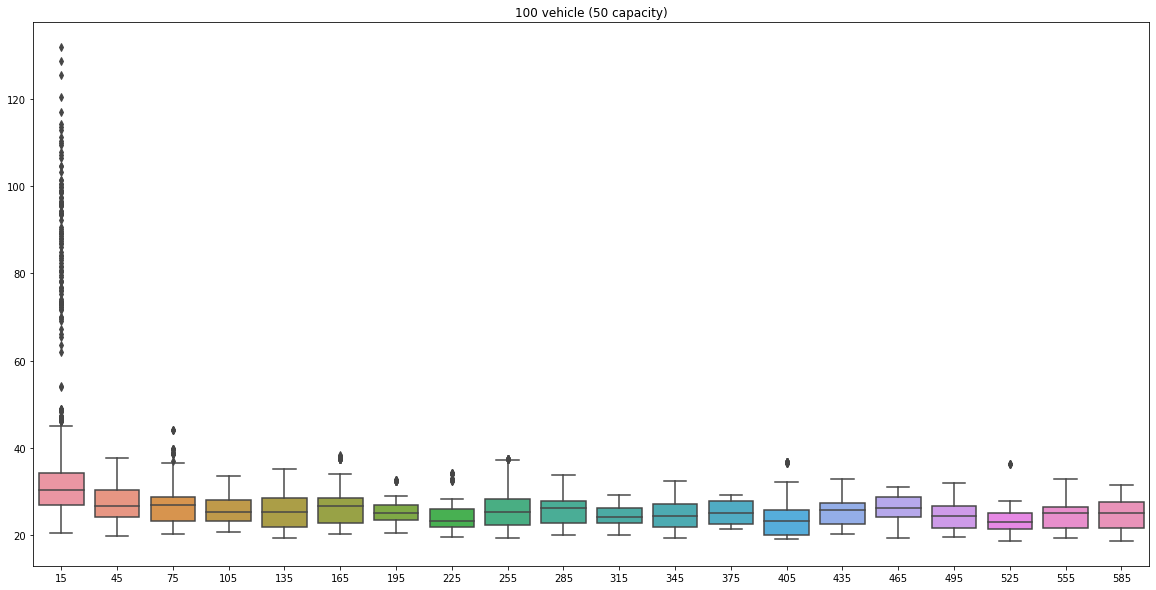

In [333]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import plotly.express as px
plt.figure(figsize = (20, 10))
plt.title("100 vehicle (50 capacity)")

# df = pd.DataFrame({'x': out[1], 'y': out[0]})
# fig = px.box(df,x = 'x',y = 'y')
# fig.show()

ax = sns.boxplot(x = list2_new, y = list1)
    
plt.savefig('100_vehicle_50_capacity.png')